# NYC MoMA Artworks - Exploratory Analysis

<section id="toc">
    <h2>Introduction</h2>
</section>

<section id="toc">
    <h2>Table of Contents</h2>
    <ol>
        <li><a href="#intro">Introduction</a></li>
        <li><a href="#load-libaries">Load Libraries</a></li>
        <li><a href="#define-funcs">Defining Data Analysis Functions</a></li>
        <li><a href="#load-data">Load Data</a></li>
        <li><a href="#data-prep">Data Preprocessing</li>
        <li><a href="#data-valid">Data Validation</a></li>
        <li><a href="#desc-stats">Define Data Quality</a></li>
        <li><a href="#ts-analysis">Collections Time Series Analysis</li>
            <ul>
            <li><a href="#acc-and-ts">Time Series Analysis & Decomposition of Acquisition Count</a>
            </ul>
        <li><a href="#gap-analysis">Collections Spatial Analysis</a></li>
        <li><a href="#conclusions">Conclusions & Recommendations</a></li>
    </ol>
</section>

<section id="load-libaries">
    <h2>Load Libraries</h2> 
</section>

In [1]:
import re  # string-searching
import os  # file-handling
import math # helpful analysis-functions
import pandas as pd  # data-manipulation
import numpy as np # data-manipulation
import scipy as scp # data-manipulation
import seaborn as sns # data-visualization
import matplotlib.pyplot as plt # data-visualization
from etl import ensure_dataset_types  # data-type enforcement
import statsmodels.api as sm  # seasonal decomposition


sns.set_style("whitegrid")
pd.set_option("display.float_format", "{:0.3f}".format)

<section id="define-funcs">
    <h2>Data Analysis Functions</h2>
</section>

In [2]:
def counts_by(column_names: str|list[str], df):
    return df[column_names].value_counts()


def detect_IQR_outliers(dataset, lower = 0.25, upper = 0.75):
    """Detects values that lie outsides of the specified IQR range."""
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)
    outliers = dataset[~((lower_outliers > dataset) | (dataset < upper_outliers))]
    
    if not outliers.any().any():
        print("There are no outliers detected in the dataset.")
    else:
        print("Columns which contain outliers outside of the 25th and 75th percentiles:")
        print(outliers.any())
        return outliers


def remove_outliers(dataset, lower = 0.25, upper = 0.75):
    # Remove numerical outliers from the dataset
    dataset.astype(np.float64)
    Q1 = dataset.quantile(lower)
    Q3 = dataset.quantile(upper)
    IQR = Q3 - Q1
    lower_outliers = Q1 - (1.5 * IQR)
    upper_outliers = Q3 + (1.5 * IQR)

    return dataset[(dataset > lower_outliers) & (dataset < upper_outliers)]


def gen_ts_features(df, date_column, more_columns):
    # Generates Time Series Features based on date_column
    # Makes for easier analysis of operational (day-to-day) processes.
    out = df[[date_column] + more_columns].copy()
    out[date_column] = pd.to_datetime(out[date_column], format = "%m/%d/%Y", errors = "coerce")
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    out["weekday"] = pd.Categorical(out[date_column].dt.day_name(), categories = weekday_order, ordered = True)
    out["day_of_month"] = out[date_column].dt.day.astype(int)
    out["day_of_year"] = out[date_column].dt.dayofyear.astype(int)
    out["week_of_month"] = (out[date_column].dt.day / 7).apply(lambda x: np.ceil(x)).astype(int)
    out["week"] = out[date_column].dt.isocalendar().week.astype(int)
    out["month"] = out[date_column].dt.month.astype(int)
    out["year"] = out[date_column].dt.isocalendar().year.astype(int)
    return out


def is_stationary(series):
    # Hypothesis Testing for Time Series data
    # Perform two separate stationarity tests
    result = stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

    if result:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")
    return result


def has_seasonality(series):
    result = check_seasonality(series)

    if result[0]:
        print(f"The time series has seaonality, with a period of {result[1]}")
    else:
        print("The time series does not have seasonality.")
    return result


def calculate_confidence_intervals_95(df: pd.DataFrame, column: str) -> tuple[float, float]:
    valid_data = df[~np.isnan(df[column])]
    # Calculate mean and 95% CI
    mean = valid_data[column].mean()
    std_err = valid_data[column].std() / np.sqrt(valid_data.shape[0])  # Standard error calculation
    lower_bound, upper_bound = (mean - 1.96 * std_err, mean + 1.96 * std_err)  # CI calculation
    return lower_bound, upper_bound

<section id="load-data">
    <h2>Load all data</h2>
</section>

In [3]:
# Load in Dataset(s)
file_path = os.path.join("./out/datasets", "NYC-MoMA-storage_group-fill.csv")
artworks_df = ensure_dataset_types(pd.read_csv(file_path, index_col=[0]))

<section id="#data-prep">
    <h2>Data Preprocessing</h2>
</section>

In [4]:
# SCAFFOLDING: Sampling to 15k points for speed-of-dev.
# SCAFFOLDING: Will remove when polishing.

# Data Preprocessing
artworks_df = artworks_df.sort_values(by=["acquisition_date", "object_number"])

# Calculate the range for the last 20 years
latest_20_years = pd.Timestamp.now() - pd.DateOffset(years=20)

# Final datasets for analysis
datasets = dict(
    artworks_data = artworks_df.copy(),
    recent_data = artworks_df[artworks_df["acquisition_date"] >= latest_20_years].copy()
)

datasets["artworks_tsdata"] = gen_ts_features(datasets["artworks_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])

datasets["recent_tsdata"] = gen_ts_features(datasets["recent_data"],
                                            "acquisition_date", 
                                            ["date", "department", "credit_group", "storage_group", "height_ft",
                                             "width_ft", "depth_ft", "cubic_ft", "spatial_running_total", 
                                             "adate_sum", "acc_gaps"])

# datasets["artworks_data"].loc[:, "acc_gaps"] = datasets["artworks_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["artworks_tsdata"].loc[:, "acc_gaps"] = datasets["artworks_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_data"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))
# datasets["recent_data"].loc[:, "acc_gaps"] = datasets["recent_tsdata"]["acc_gaps"].apply(lambda x: np.abs(pd.Timedelta(x).days))

categorical_columns = datasets["artworks_data"].select_dtypes(include=["object", "category", "datetime64[ns]"]).columns
numerical_columns = datasets["artworks_data"].select_dtypes(exclude=["object", "category", "datetime64[ns]"]).columns
spatial_columns = [
    "height_ft",
    "width_ft",
    "depth_ft",
    "cubic_ft",
    "spatial_running_total",
]
# Point-of-Interest 
# Categorical columns which are most relevant for inventory analysis + forecasting
hue_categories = ["credit_group", "department",  "storage_group"]


<section id="data-valid">
    <h2>Data Validation</h2>
</section>

In [5]:
datasets["artworks_data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130262 entries, 55947 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   126810 non-null  datetime64[ns]
 1   acquisition_date       130262 non-null  datetime64[ns]
 2   credit                 127192 non-null  object        
 3   department             130262 non-null  object        
 4   classification         130262 non-null  object        
 5   object_number          130262 non-null  object        
 6   credit_group           130262 non-null  object        
 7   storage_group          130262 non-null  object        
 8   height_ft              130262 non-null  float64       
 9   width_ft               130262 non-null  float64       
 10  depth_ft               130262 non-null  float64       
 11  cubic_ft               130262 non-null  float64       
 12  spatial_running_total  130262 non-null  

In [6]:
datasets["recent_data"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39031 entries, 93780 to 129943
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   36961 non-null  datetime64[ns]
 1   acquisition_date       39031 non-null  datetime64[ns]
 2   credit                 38833 non-null  object        
 3   department             39031 non-null  object        
 4   classification         39031 non-null  object        
 5   object_number          39031 non-null  object        
 6   credit_group           39031 non-null  object        
 7   storage_group          39031 non-null  object        
 8   height_ft              39031 non-null  float64       
 9   width_ft               39031 non-null  float64       
 10  depth_ft               39031 non-null  float64       
 11  cubic_ft               39031 non-null  float64       
 12  spatial_running_total  39031 non-null  float64       
 

In [7]:
datasets["artworks_data"].head()

date acquisition_date                 credit  \
55947 1914-01-01       1929-11-19  Gift of Paul J. Sachs   
55999 1923-01-01       1929-11-19  Gift of Paul J. Sachs   
56011 1922-01-01       1929-11-19  Gift of Paul J. Sachs   
56012 1923-01-01       1929-11-19      Given anonymously   
31549 1926-01-01       1929-11-19  Gift of Paul J. Sachs   

                       department classification object_number credit_group  \
55947  Prints & Illustrated Books          Print        1.1929         Gift   
55999  Prints & Illustrated Books          Print        2.1929         Gift   
56011  Prints & Illustrated Books          Print        3.1929         Gift   
56012  Prints & Illustrated Books          Print        3.1931         Gift   
31549                    Drawings        Drawing        4.1929         Gift   

        storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
55947  Works on Paper      7.833     0.581     0.077     0.352   
55999  Works on Paper      0.745     0.571     0.077     0.033   
56011  Works on Paper      1.486     1.204     0.077     0.138   
56012  Works on Paper      1.424     0.886     0.077     0.098   
31549  Works on Paper      2.250     1.760     0.077     0.306   

       spatial_running_total  adate_sum acc_gaps  
55947             532853.711         10   0 days  
55999             532853.359         10   0 days  
56011             532853.326         10   0 days  
56012             532853.188         10   0 days  
31549             532853.090         10   0 days

In [8]:
datasets["recent_data"].head()

date acquisition_date  \
93780 2001-01-01       2004-10-26   
90011 2004-01-01       2004-11-01   
90012        NaT       2004-11-01   
93781 1997-01-01       2004-11-11   
86488 1997-01-01       2004-12-01   

                                                  credit  \
93780                                           Purchase   
90011                                                NaN   
90012                         Gift of Herbert C. Bernard   
93781  Gift of Marian and James H. Cohen in memory of...   
86488  Fractional and promised gift of Thea Westreich...   

                      department classification object_number credit_group  \
93780  Media and Performance Art          Video      556.2004     Purchase   
90011                       Film          Video         37945        Other   
90012                   Drawings        Drawing    502.1965.b         Gift   
93781  Media and Performance Art   Installation      555.2004         Gift   
86488  Media and Performance Art   Installation      537.2004         Gift   

           storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
93780         Time-based      0.577     0.563     0.033     0.011   
90011         Time-based      0.577     0.563     0.033     0.011   
90012     Works on Paper      1.000     0.823     0.077     0.064   
93781  Production Design      2.986     3.768     2.275    25.599   
86488  Production Design      2.986     3.768     2.275    25.599   

       spatial_running_total  adate_sum  acc_gaps  
93780             149640.183          1   -6 days  
90011             149640.172          2    0 days  
90012             149640.162          2  -10 days  
93781             149640.098          1  -20 days  
86488             149614.499          1  -12 days

In [9]:
datasets["artworks_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  adate_sum acc_gaps  
130193                  0.184          8   0 days  
128295                  0.173          8   0 days  
129942                  0.032          8   0 days  
118992                  0.021          8   0 days  
129943                  0.011          8      NaN

In [10]:
datasets["recent_data"].tail()

date acquisition_date  \
130193 2013-01-01       2016-12-15   
128295 2013-01-01       2016-12-15   
129942 2014-01-01       2016-12-15   
118992 1971-01-01       2016-12-15   
129943 2005-01-01       2016-12-15   

                                                   credit  \
130193  Committee on Media and Performance Art and Pau...   
128295                                 Gift of Paul Leong   
129942                                 Gift of the artist   
118992                              Gift of Virginia Dwan   
129943                      The Contemporary Arts Council   

                       department classification  object_number credit_group  \
130193  Media and Performance Art    Performance  1351.2016.1-2        Other   
128295  Media and Performance Art  Work on Paper    1351.2016.2         Gift   
129942  Media and Performance Art          Video      1352.2016         Gift   
118992  Media and Performance Art          Video      1353.2016         Gift   
129943  Media and Performance Art          Video      1354.2016        Other   

         storage_group  height_ft  width_ft  depth_ft  cubic_ft  \
130193      Time-based      0.577     0.563     0.033     0.011   
128295  Works on Paper      1.366     1.340     0.077     0.142   
129942      Time-based      0.577     0.563     0.033     0.011   
118992      Time-based      0.577     0.563     0.033     0.011   
129943      Time-based      0.577     0.563     0.033     0.011   

        spatial_running_total  adate_sum acc_gaps  
130193                  0.184          8   0 days  
128295                  0.173          8   0 days  
129942                  0.032          8   0 days  
118992                  0.021          8   0 days  
129943                  0.011          8      NaN

In [11]:
datasets["artworks_data"].isna().sum()

date                     3452
acquisition_date            0
credit                   3070
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
adate_sum                   0
acc_gaps                    1
dtype: int64

In [12]:
datasets["recent_data"].isna().sum()

date                     2070
acquisition_date            0
credit                    198
department                  0
classification              0
object_number               0
credit_group                0
storage_group               0
height_ft                   0
width_ft                    0
depth_ft                    0
cubic_ft                    0
spatial_running_total       0
adate_sum                   0
acc_gaps                    1
dtype: int64

## Descriptive Statistics

In [13]:
print("Overall Collections Analysis Dataset Columns\n")
print("Categorical Columns:\n", list(categorical_columns), "\n")
print("Numerical Columns:\n", list(numerical_columns))

print("\nRecent (20 Years) Collections Analysis Dataset Columns\n", list(datasets["recent_data"].columns))

print("\nAre the columns identical?\n", (datasets["artworks_data"].columns == datasets["recent_data"].columns).all())

Overall Collections Analysis Dataset Columns

Categorical Columns:
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'acc_gaps'] 

Numerical Columns:
 ['height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum']

Recent (20 Years) Collections Analysis Dataset Columns
 ['date', 'acquisition_date', 'credit', 'department', 'classification', 'object_number', 'credit_group', 'storage_group', 'height_ft', 'width_ft', 'depth_ft', 'cubic_ft', 'spatial_running_total', 'adate_sum', 'acc_gaps']

Are the columns identical?
 True


In [14]:
datasets["artworks_data"].describe().T

count       mean        std   min        25%  \
height_ft             130262.000      1.221      1.475 0.000      0.623   
width_ft              130262.000      1.245      2.051 0.000      0.610   
depth_ft              130262.000      0.233      0.637 0.000      0.077   
cubic_ft              130262.000      4.091    309.676 0.000      0.043   
spatial_running_total 130262.000 293964.942 175080.791 0.011 127231.869   
adate_sum             130262.000   1712.830   3224.741 1.000    118.000   

                             50%        75%        max  
height_ft                  0.937      1.385    299.869  
width_ft                   0.932      1.417    300.000  
depth_ft                   0.143      0.155     59.333  
cubic_ft                   0.109      0.226  97194.694  
spatial_running_total 330225.255 500449.607 532853.711  
adate_sum                294.000    889.000  11220.000

In [15]:
datasets["recent_data"].describe().T

count      mean       std   min       25%       50%  \
height_ft             39031.000     1.262     2.111 0.000     0.583     0.937   
width_ft              39031.000     1.312     2.093 0.000     0.584     0.938   
depth_ft              39031.000     0.245     0.724 0.000     0.077     0.077   
cubic_ft              39031.000     3.834   205.036 0.000     0.018     0.099   
spatial_running_total 39031.000 72052.779 49102.085 0.011 25593.933 91690.821   
adate_sum             39031.000  1195.500  1771.794 1.000   149.000   376.000   

                             75%        max  
height_ft                  1.438    299.869  
width_ft                   1.474    153.000  
depth_ft                   0.143     59.333  
cubic_ft                   0.244  36861.058  
spatial_running_total 106925.905 149640.183  
adate_sum                849.000   5359.000

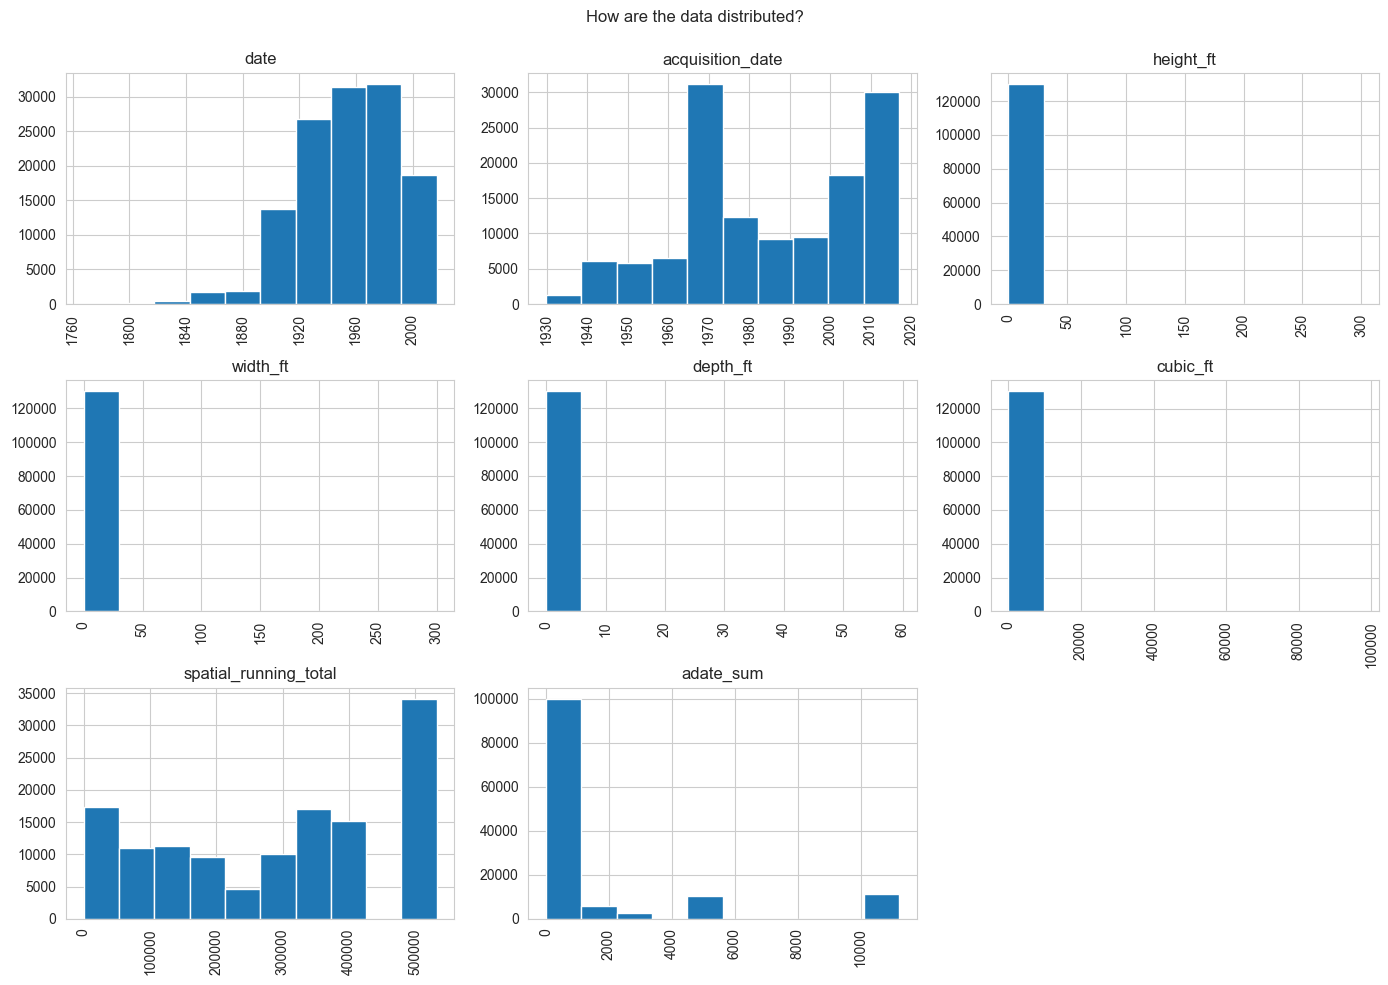

In [16]:
datasets["artworks_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

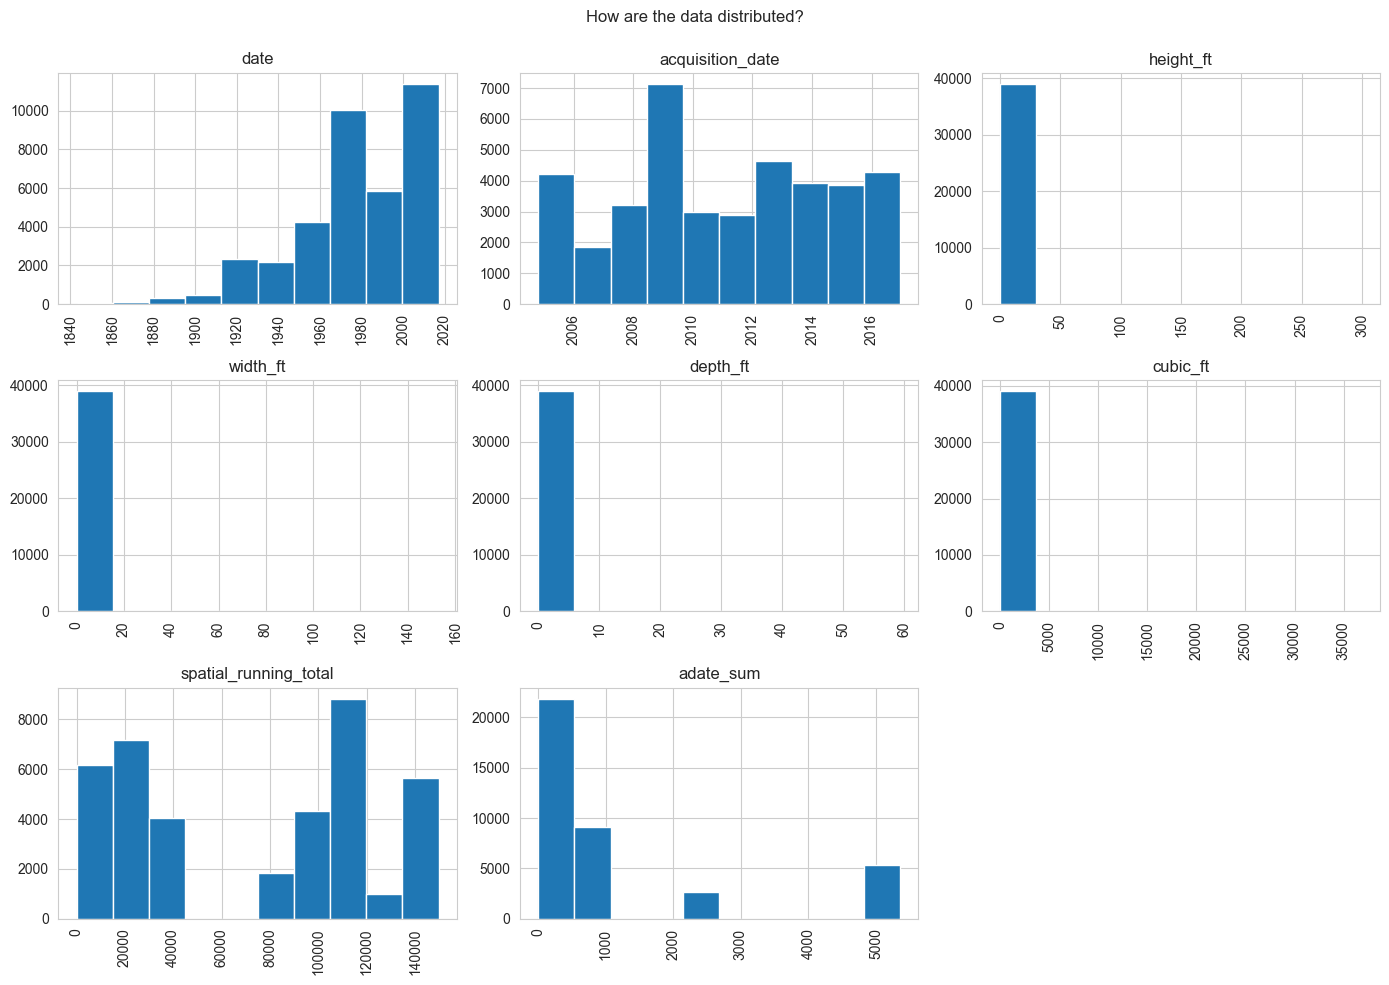

In [17]:
datasets["recent_data"].hist(
    figsize = (14, 10), 
    xrot = 90,
)
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

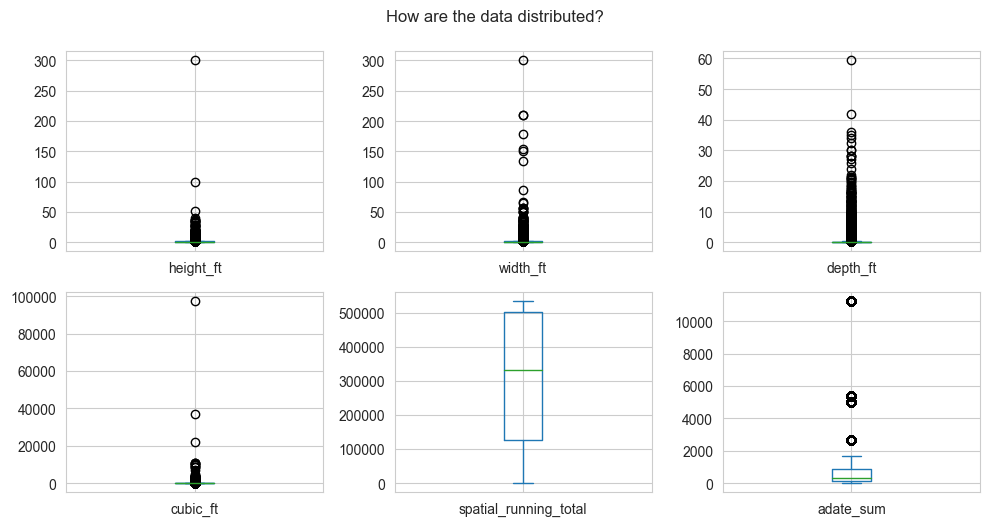

In [18]:
datasets["artworks_data"].plot(
    figsize=(10, 10), 
    kind="box", 
    subplots=True, 
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

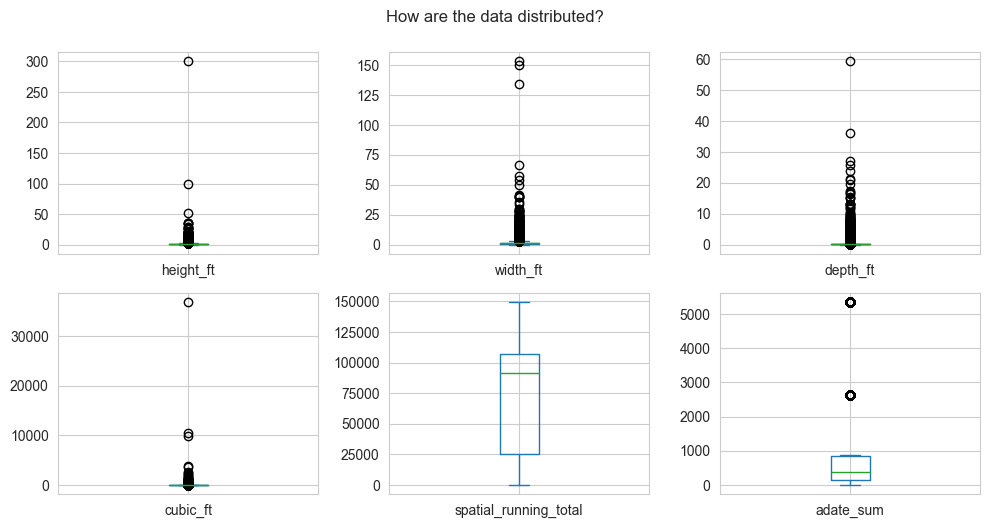

In [19]:
datasets["recent_data"].plot(
    figsize=(10, 10),
    kind="box",
    subplots=True,
    layout=(4, 3)
);
plt.suptitle("How are the data distributed?\n")
plt.tight_layout()
plt.show()
plt.close()

In [20]:
# TODO: Display which Object Numbers are connected to spatial outliers
outliers = detect_IQR_outliers(datasets["artworks_data"].select_dtypes("number"))

Columns which contain outliers outside of the 25th and 75th percentiles:
height_ft                 True
width_ft                  True
depth_ft                  True
cubic_ft                  True
spatial_running_total    False
adate_sum                 True
dtype: bool


In [21]:
ts_columns = pd.Index(["day_of_month", "day_of_year", "week_of_month", "week", "month", "year"])

datasets["artworks_data"].loc[:, numerical_columns] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))
datasets["artworks_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["artworks_data"].select_dtypes("number"))

datasets["recent_data"].loc[:, numerical_columns] = remove_outliers(datasets["recent_data"].select_dtypes("number"))
datasets["recent_tsdata"].loc[:, numerical_columns.difference(ts_columns)] = remove_outliers(datasets["recent_data"].select_dtypes("number"))

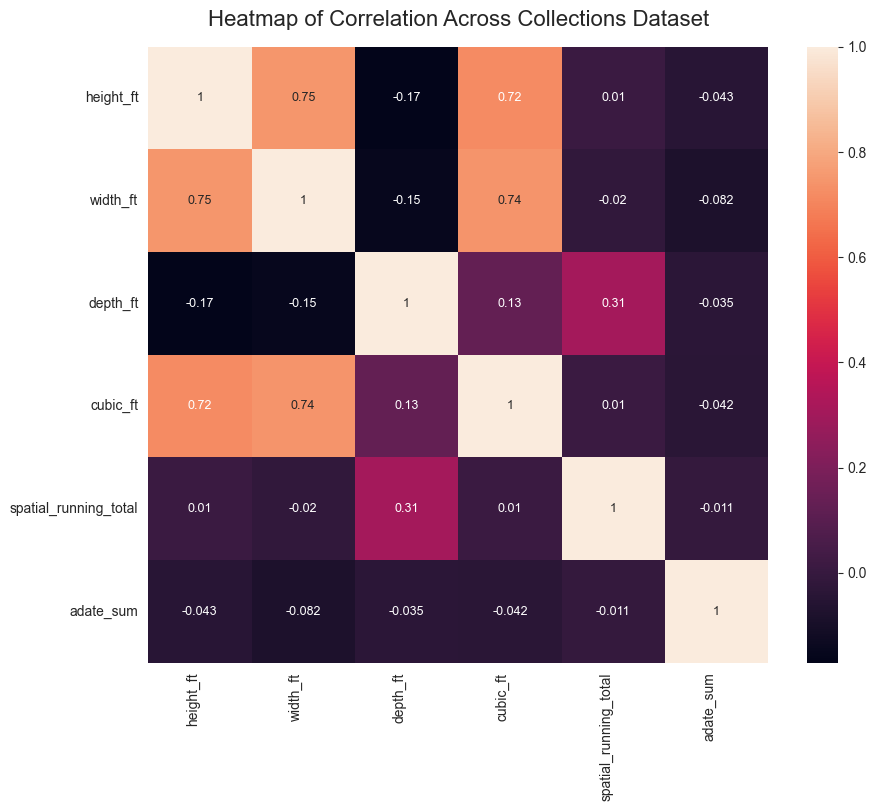

In [22]:
corr_matrix = datasets["artworks_data"].drop(columns=["acc_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

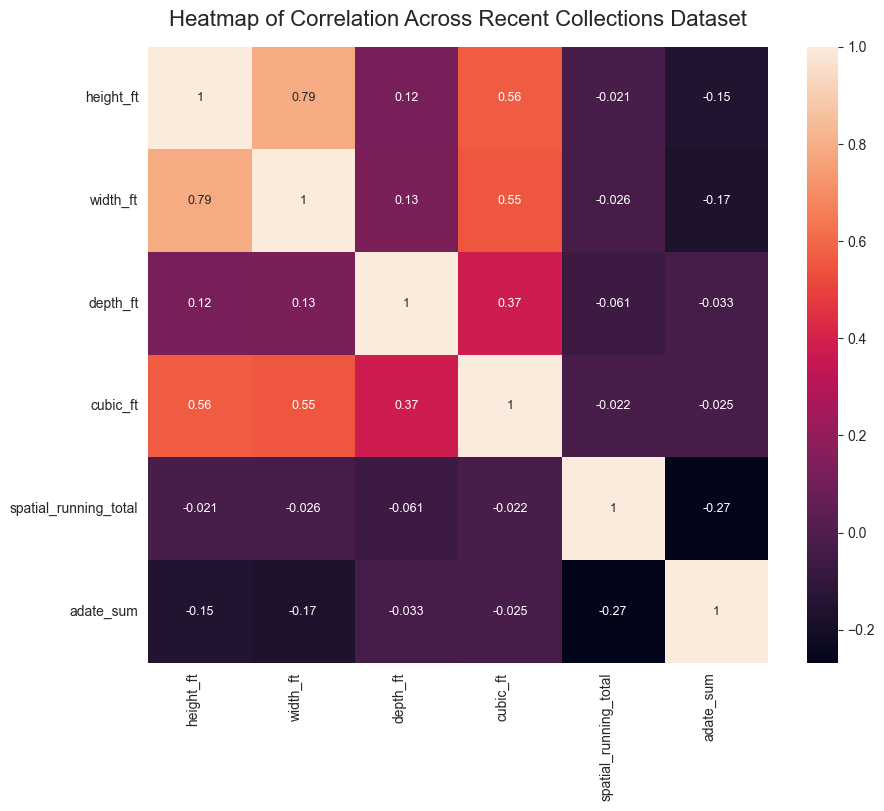

In [23]:
corr_matrix = datasets["recent_data"].drop(columns = ["acc_gaps"]).corr(numeric_only = True)
plt.figure(figsize = (10, 8))
heat_map = sns.heatmap(corr_matrix, annot = True, annot_kws = {"size": 9})
heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=90, horizontalalignment='right')
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.title("Heatmap of Correlation Across Recent Collections Dataset", pad = 15.0, fontsize = 16.0, y = 1.0);
plt.show()
plt.close()

<section id="ts-analysis">
    <h2>Collections Time Series Analysis</h2>
</section>

Explain here why I use the overall dataset and a subset of the overall dataset. Motivated by having the high-level perspective of overall data integrity, and a more nuanced view for interpreting more recent data for estimation purposes.
<br>

<section id="acc-analysis">
    <h3>Accessions Analysis & Decomposition</h3>
</section>

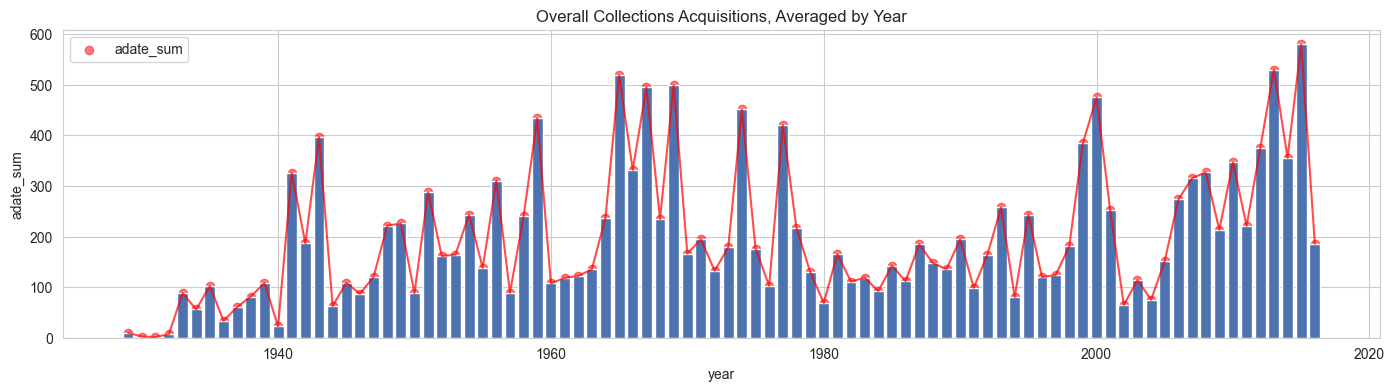

In [24]:
# Accession counts over all-time
yearly_means = datasets["artworks_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.scatter(x = "year", y = "adate_sum", color = "red", marker = "o", data = yearly_means, alpha = 0.5)
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.title("Overall Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

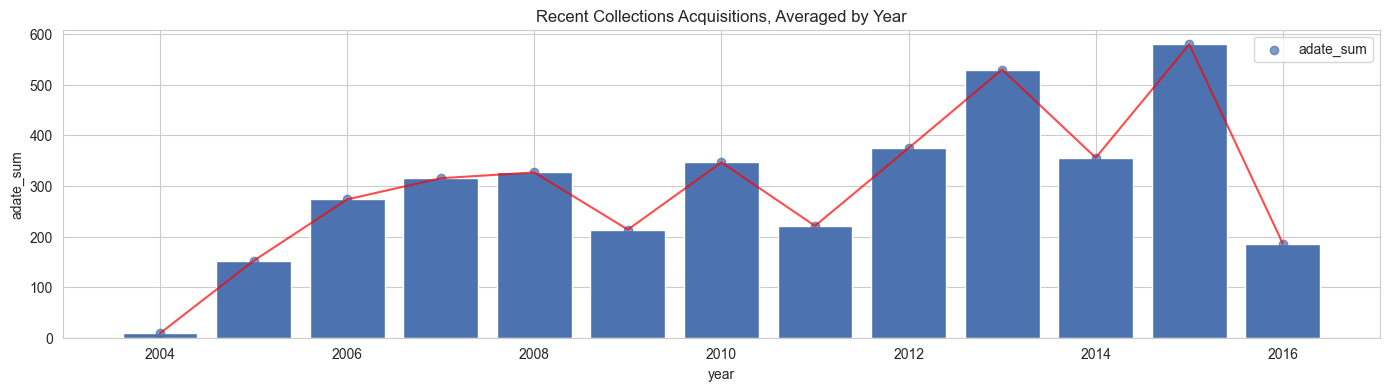

In [25]:
yearly_means = datasets["recent_tsdata"].groupby("year").mean(numeric_only = True).reset_index()
plt.figure(figsize = (17, 4))
plt.bar(x = "year", height = "adate_sum", color = sns.color_palette("deep")[0], data = yearly_means)
plt.scatter(x = "year", y = "adate_sum", color = sns.color_palette("deep")[0], marker = "o", data = yearly_means, alpha = 0.7)
sns.lineplot(yearly_means, x = "year", y = "adate_sum", color = "red", alpha = 0.7)
plt.title("Recent Collections Acquisitions, Averaged by Year");
plt.show()
plt.close()

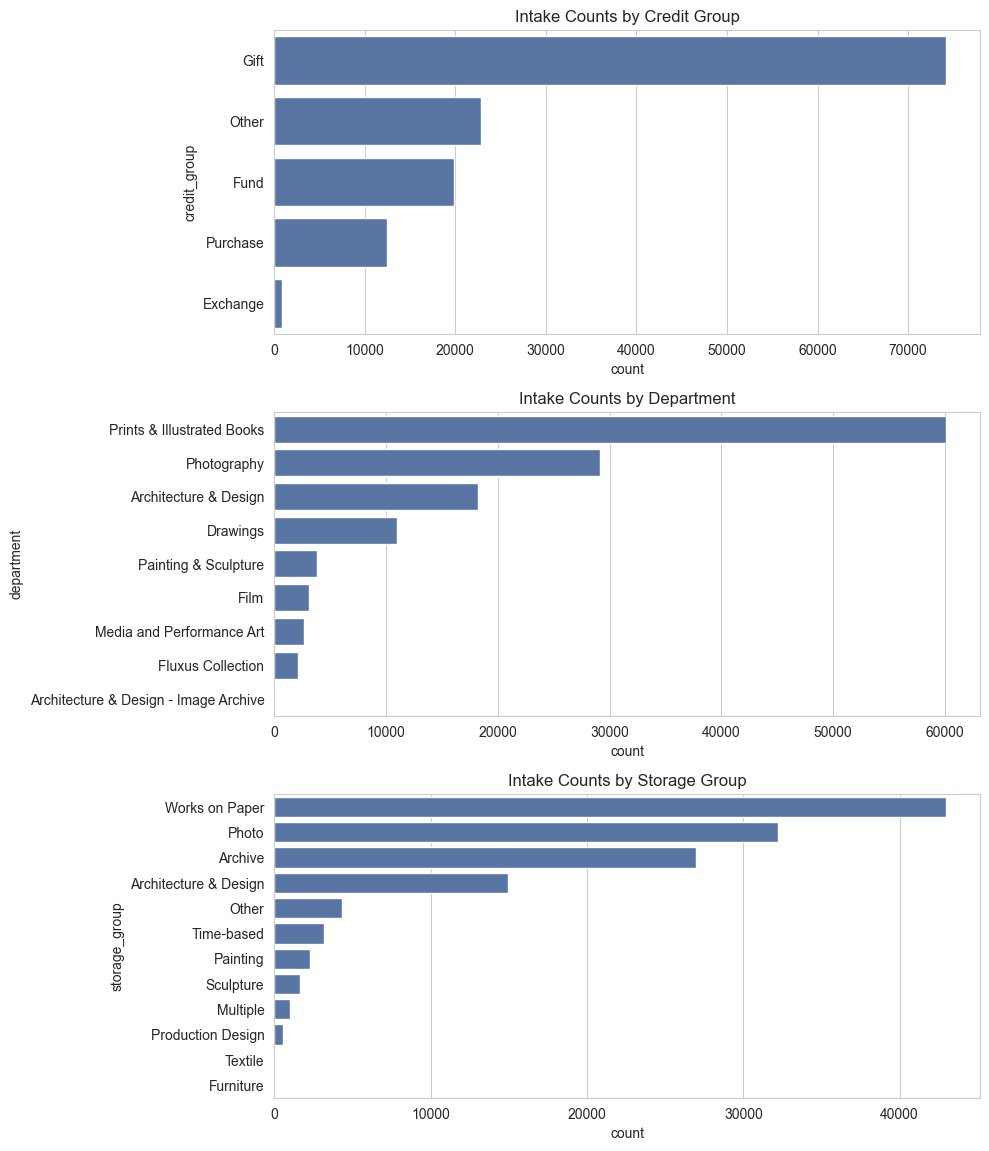

In [26]:
# Overall accession counts by credit, department, and storage group
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["artworks_data"],
        # sorts plots by descending order for visual clarity
        order = datasets["artworks_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

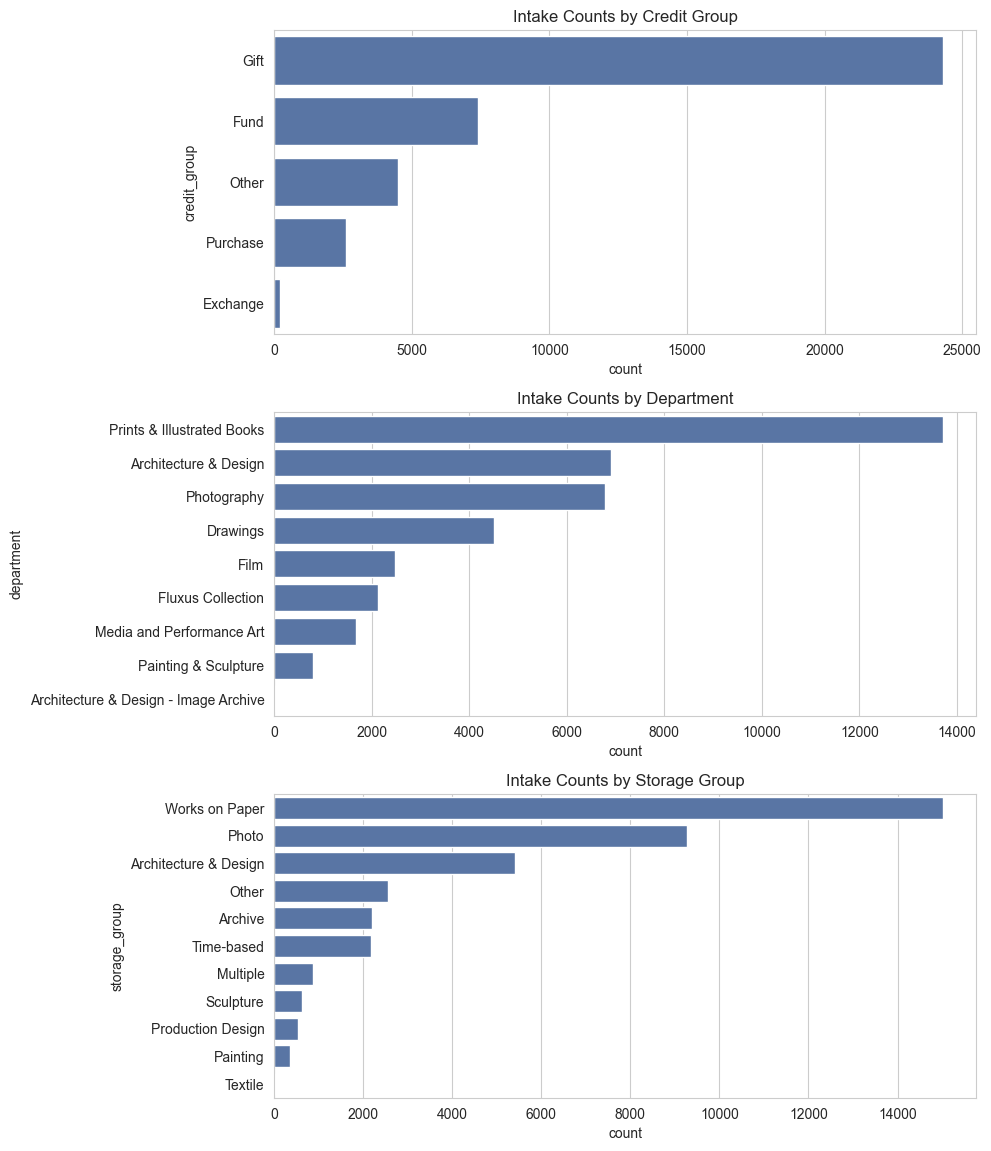

In [27]:
plt.figure(figsize = (10, 15))
for idx, category in enumerate(hue_categories, 1):
    # Acquistion date counts
    plt.subplot(4, 1, idx)
    sns.countplot(
        y = category,
        data = datasets["recent_tsdata"],
        # sorts plots by descending order for visual clarity
        order = datasets["recent_data"][category].value_counts().index,
        color = sns.color_palette("deep")[0]
    )
    plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
plt.tight_layout()
plt.show()

<section id="gap-analysis">
    <h2>Time Series Analysis of Acquisition Counts</h2>
</section>

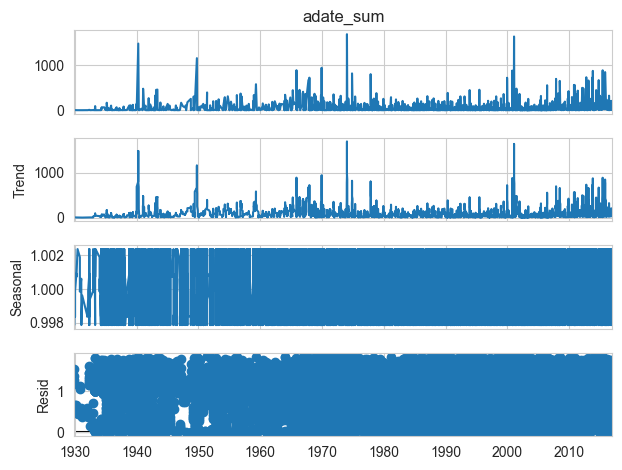

In [28]:
ts_data = (datasets["artworks_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

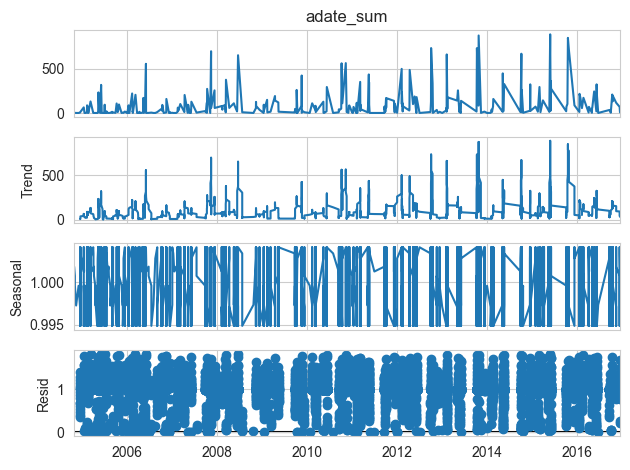

In [29]:
ts_data = (datasets["recent_data"]
           .set_index("acquisition_date")
           .sort_index()
           ["adate_sum"]
           .dropna())
decomposition = sm.tsa.seasonal_decompose(ts_data, model="multiplicative", period = 12)
decomposition.plot();

In [30]:
n = 25
print("Overall Durations of Gaps in between Acquisitions")
# print("Longest gap:", datasets["artworks_data"]["acc_gaps"].max())
# print("Shortest gap:", datasets["artworks_data"]["acc_gaps"].min())
# print("Average gap:", datasets["artworks_data"]["acc_gaps"].mean())
print(f"Top {n} Most Common gap durations:\n", datasets["artworks_data"]["acc_gaps"].value_counts().head(n))

Overall Durations of Gaps in between Acquisitions
Top 25 Most Common gap durations:
 0 days      128387
-1 days        318
-2 days        137
-3 days        112
-5 days         88
-4 days         84
-6 days         79
-7 days         78
-8 days         61
-9 days         54
-10 days        43
-28 days        40
-11 days        40
-21 days        39
-13 days        39
-15 days        38
-12 days        38
-14 days        36
-18 days        33
-19 days        33
-20 days        32
-22 days        28
-16 days        25
-26 days        24
-17 days        23
Name: acc_gaps, dtype: int64


In [31]:
n = 25
print("Latest 20 Years of Durations of Gaps in between Acquisitions")
# print("Longest gap:", datasets["recent_data"]["acc_gaps"].max())
# print("Shortest gap:", datasets["recent_data"]["acc_gaps"].min())
# print("Average gap:", datasets["recent_data"]["acc_gaps"].mean())
print(f"Top {n} Most Common gap durations:\n", datasets["recent_data"]["acc_gaps"].value_counts().head(n))

Latest 20 Years of Durations of Gaps in between Acquisitions
Top 25 Most Common gap durations:
 0 days      38675
-1 days        99
-2 days        35
-3 days        19
-4 days        18
-7 days        16
-6 days        15
-5 days        14
-11 days       10
-8 days         9
-18 days        8
-12 days        8
-27 days        7
-20 days        7
-10 days        7
-13 days        6
-21 days        6
-15 days        5
-9 days         5
-26 days        5
-34 days        4
-24 days        3
-22 days        3
-42 days        3
-19 days        3
Name: acc_gaps, dtype: int64


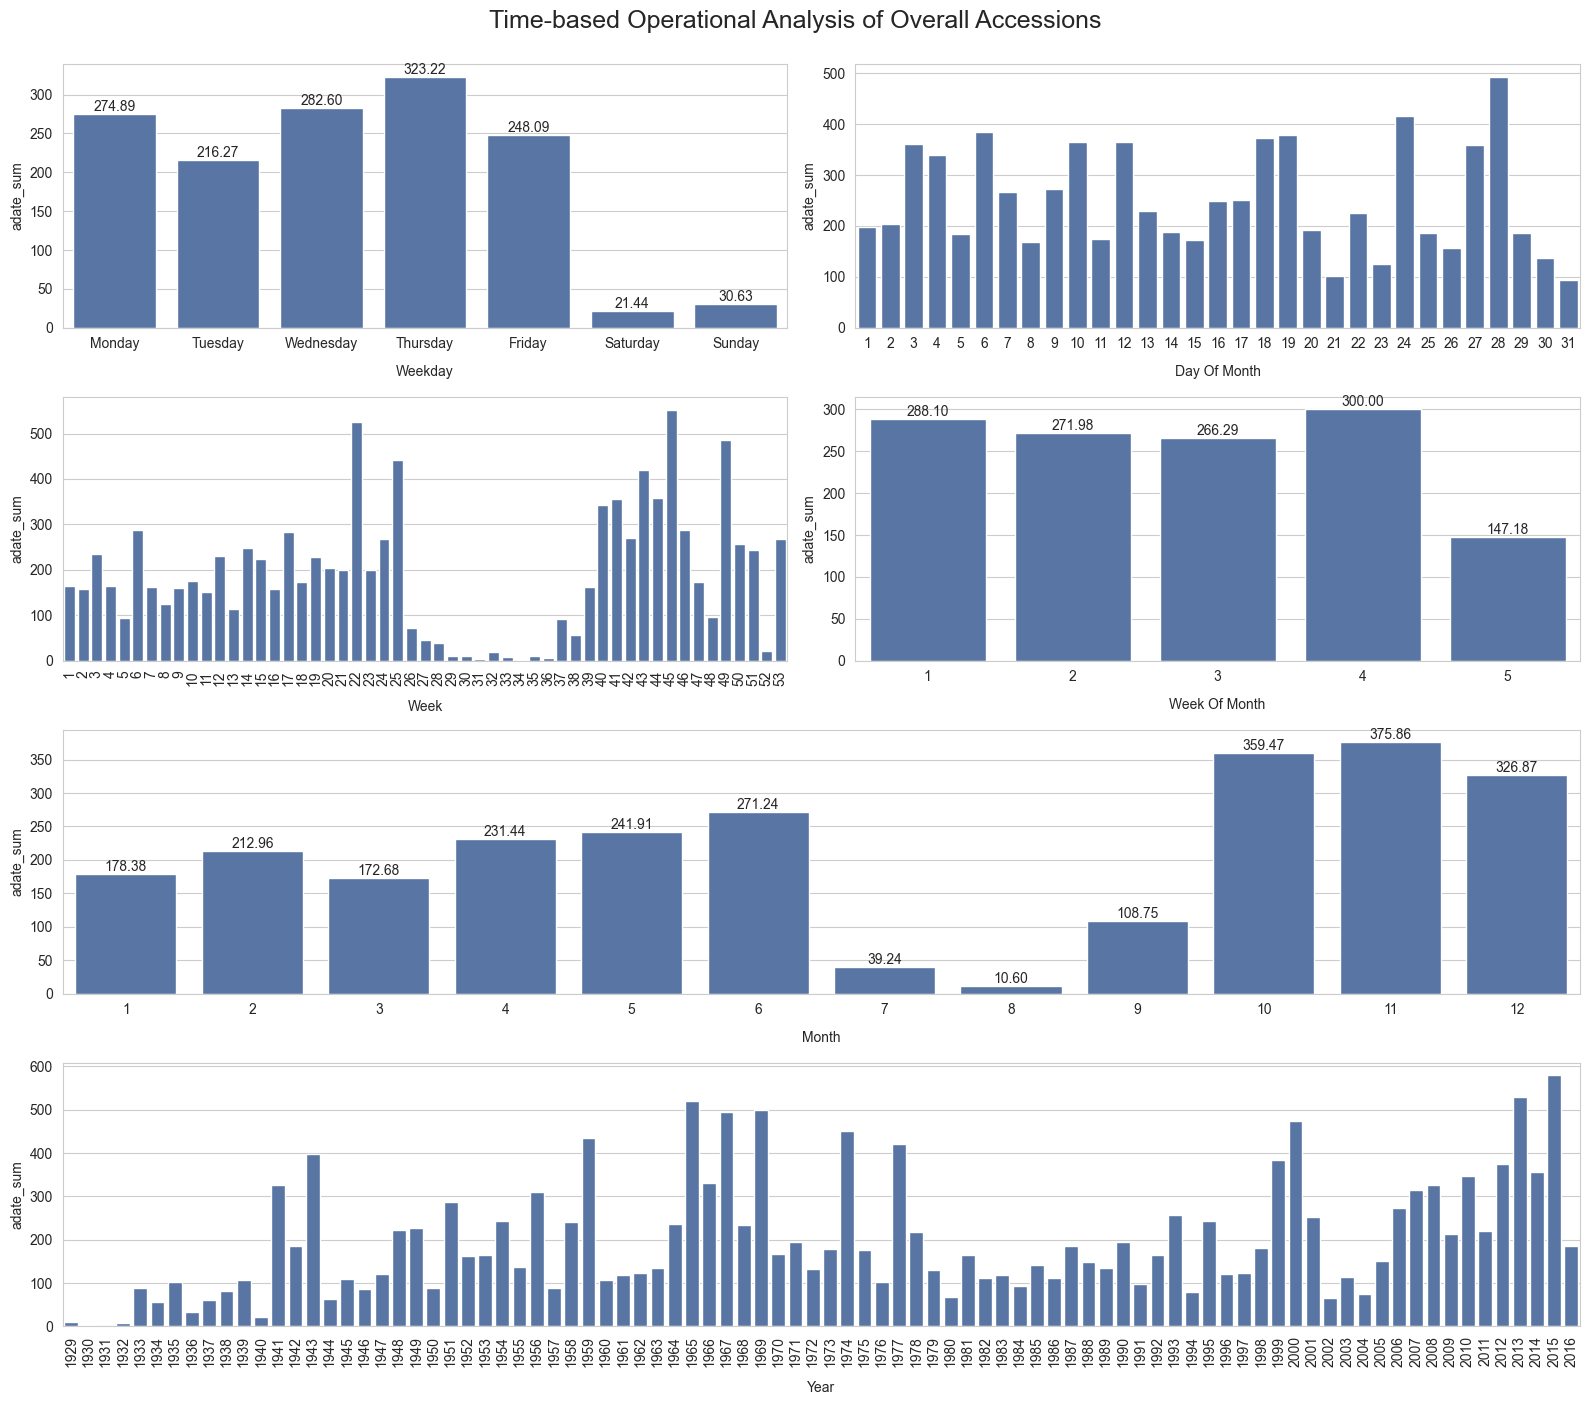

In [32]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Overall Accessions", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["artworks_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["artworks_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["artworks_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

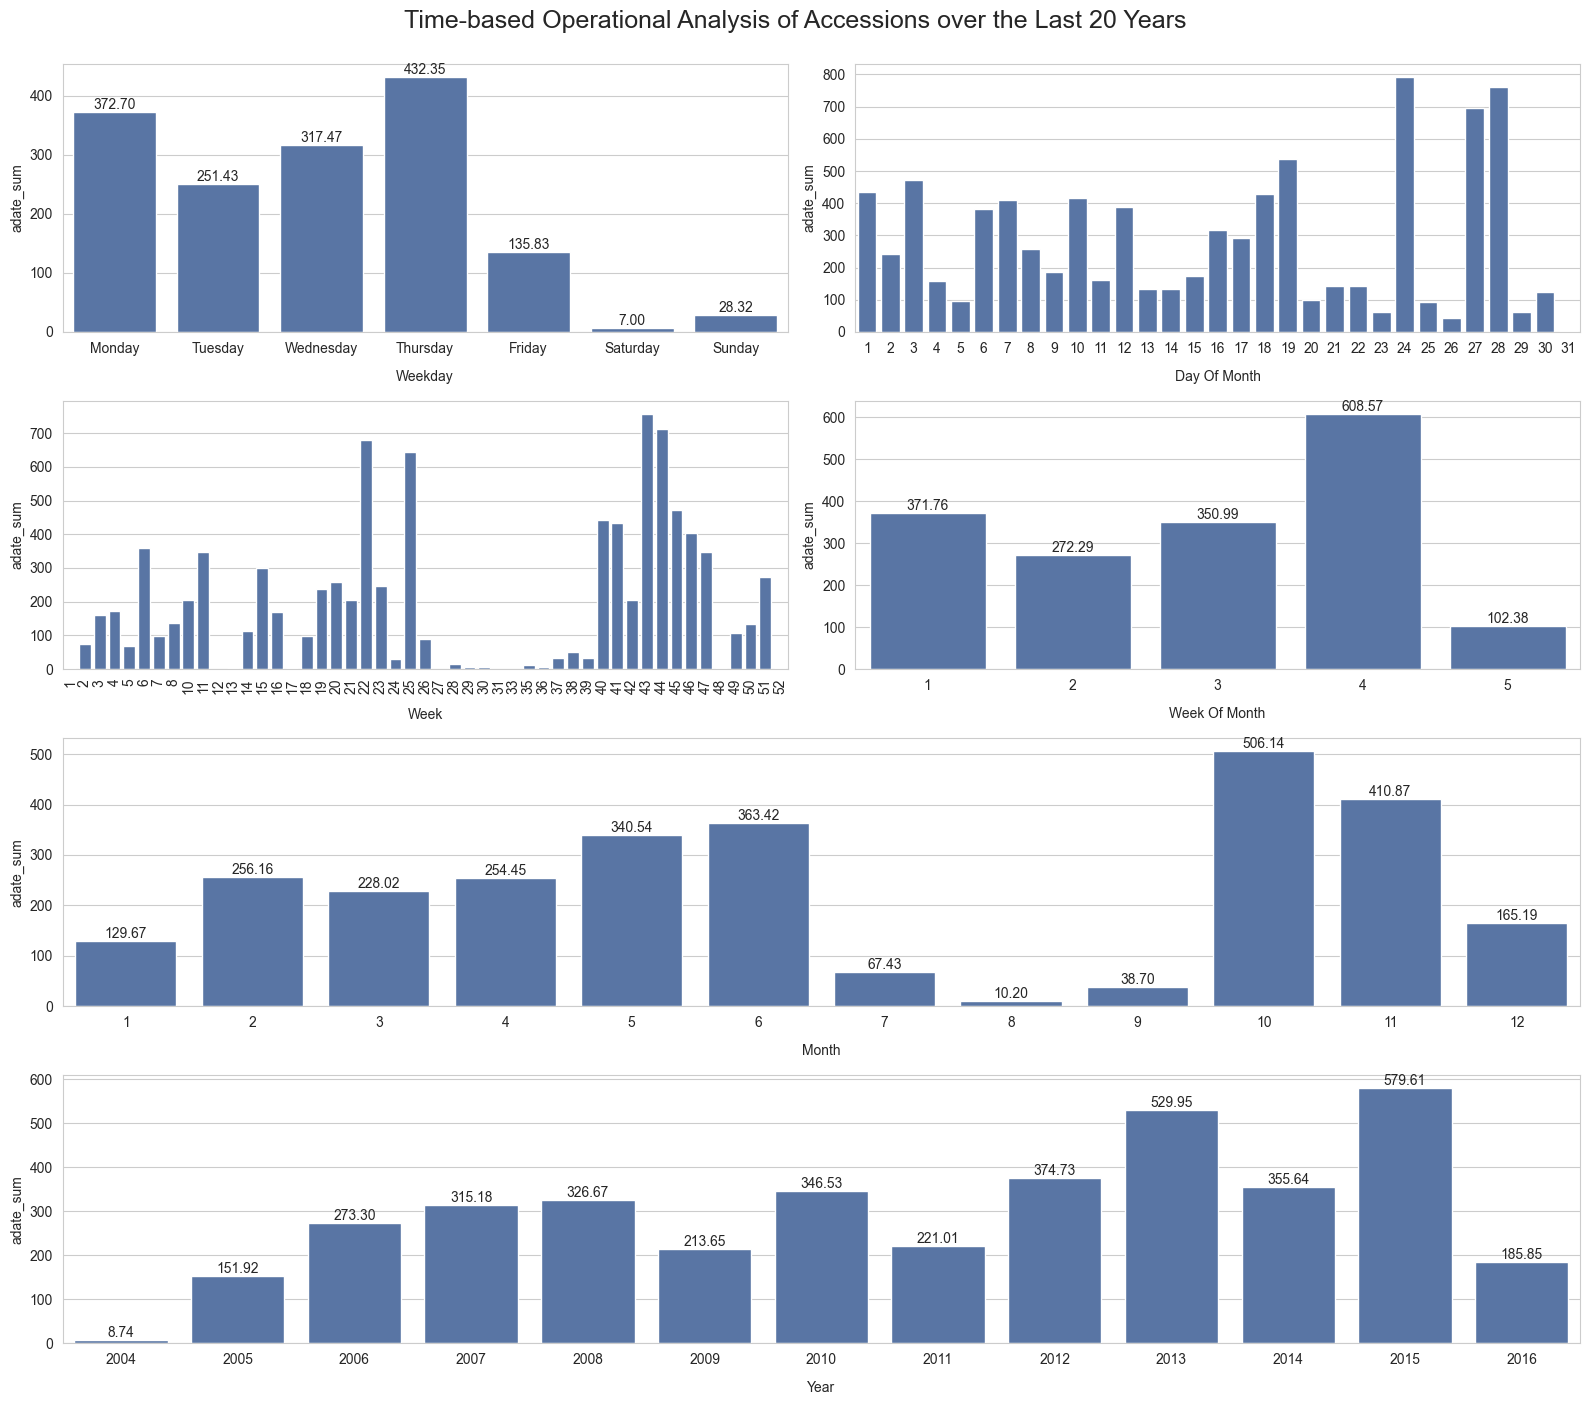

In [33]:
time_columns = ["weekday", "day_of_month", "week", "week_of_month", "month", "year"]
fig, axs = plt.subplots(4, 2, figsize=(16, 14))
plt.suptitle(f"Time-based Operational Analysis of Accessions over the Last 20 Years", fontsize = 18, y = 1.0)

for i, column in enumerate(time_columns[:-2]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.barplot(data=datasets["recent_tsdata"], x = column, y = "adate_sum", ax = ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
    ax.set_xlabel(column.title().replace("_", " "), labelpad = 10)
    if len(datasets["recent_tsdata"][column].unique()) <= 8:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom')
    plt.tight_layout()
axs[2, 1].remove()
axs[2, 0].remove()
axs[3, 1].remove()
axs[3, 0].remove()

combined_ax = fig.add_subplot(4, 1, 3)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "month", y = "adate_sum", ax = combined_ax, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax.set_xlabel("month".title(), labelpad = 10)
for p in combined_ax.patches:
    combined_ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

combined_ax2 = fig.add_subplot(4, 1, 4)  # combined plot row
sns.barplot(data = datasets["recent_tsdata"], x = "year", y = "adate_sum", ax = combined_ax2, color = sns.color_palette("deep")[0], errorbar=("ci", False))
combined_ax2.set_xlabel("year".title(), labelpad = 10)
for p in combined_ax2.patches:
    combined_ax2.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Rotate x-axis labels for "week" and "year"
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation = 90)  # For "week"
# combined_ax2.set_xticklabels(combined_ax2.get_xticklabels(), rotation = 90)  # For "year"
plt.tight_layout()
plt.show()
plt.close(fig)

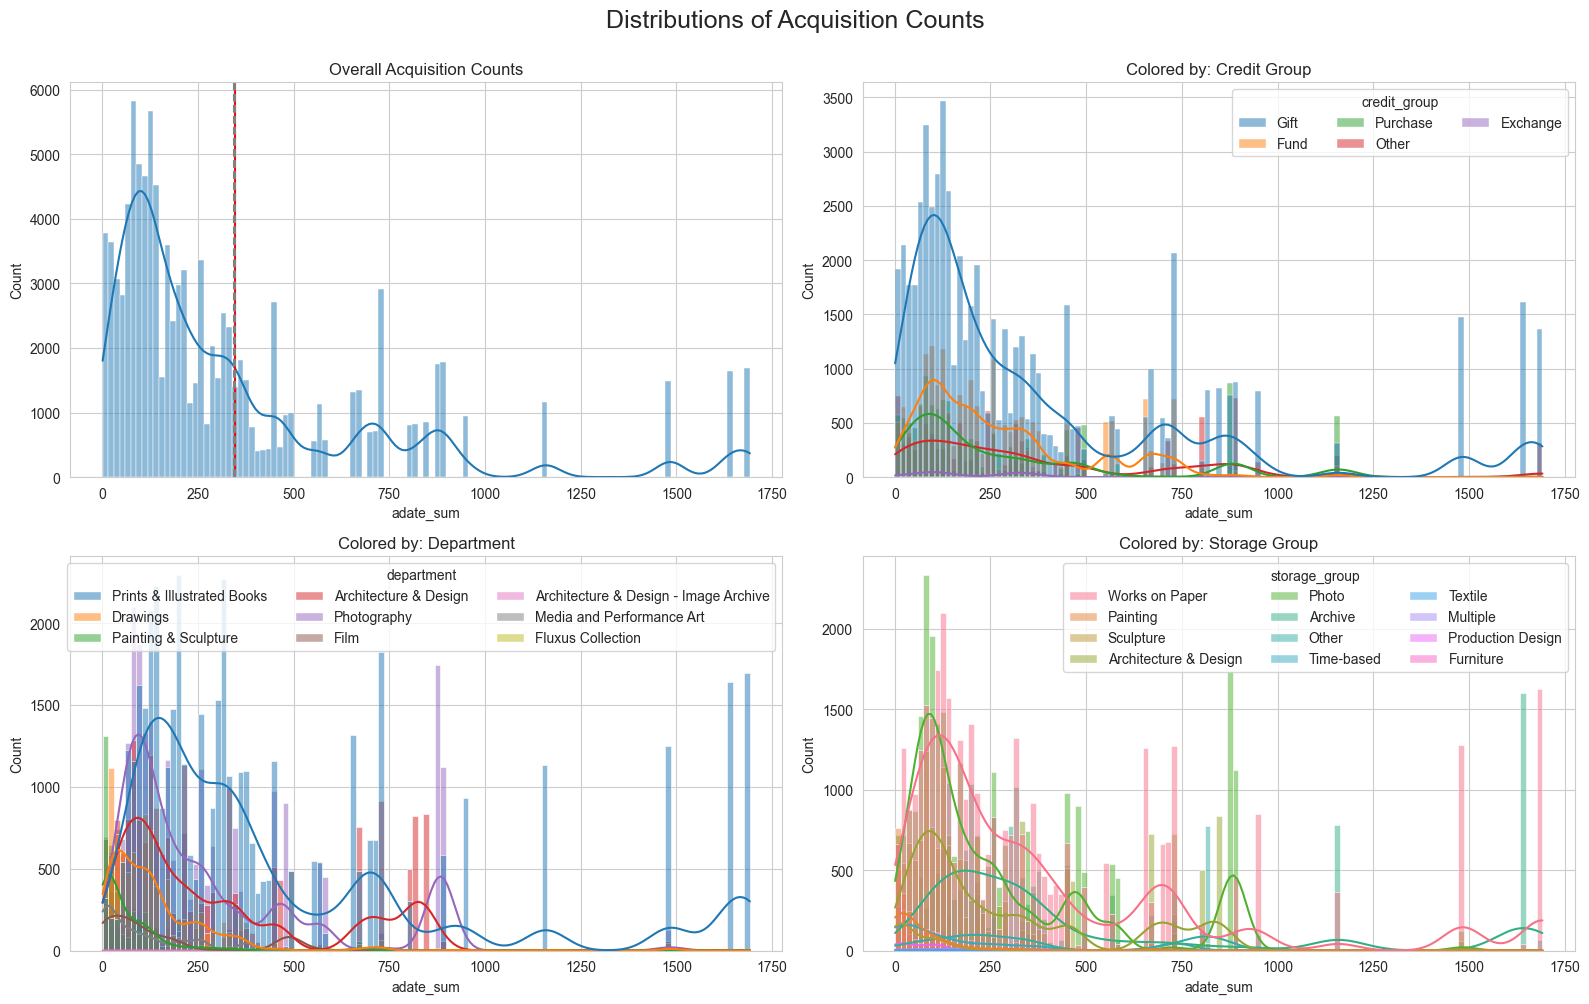

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "adate_sum")
sns.histplot(data=datasets["artworks_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["artworks_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["artworks_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

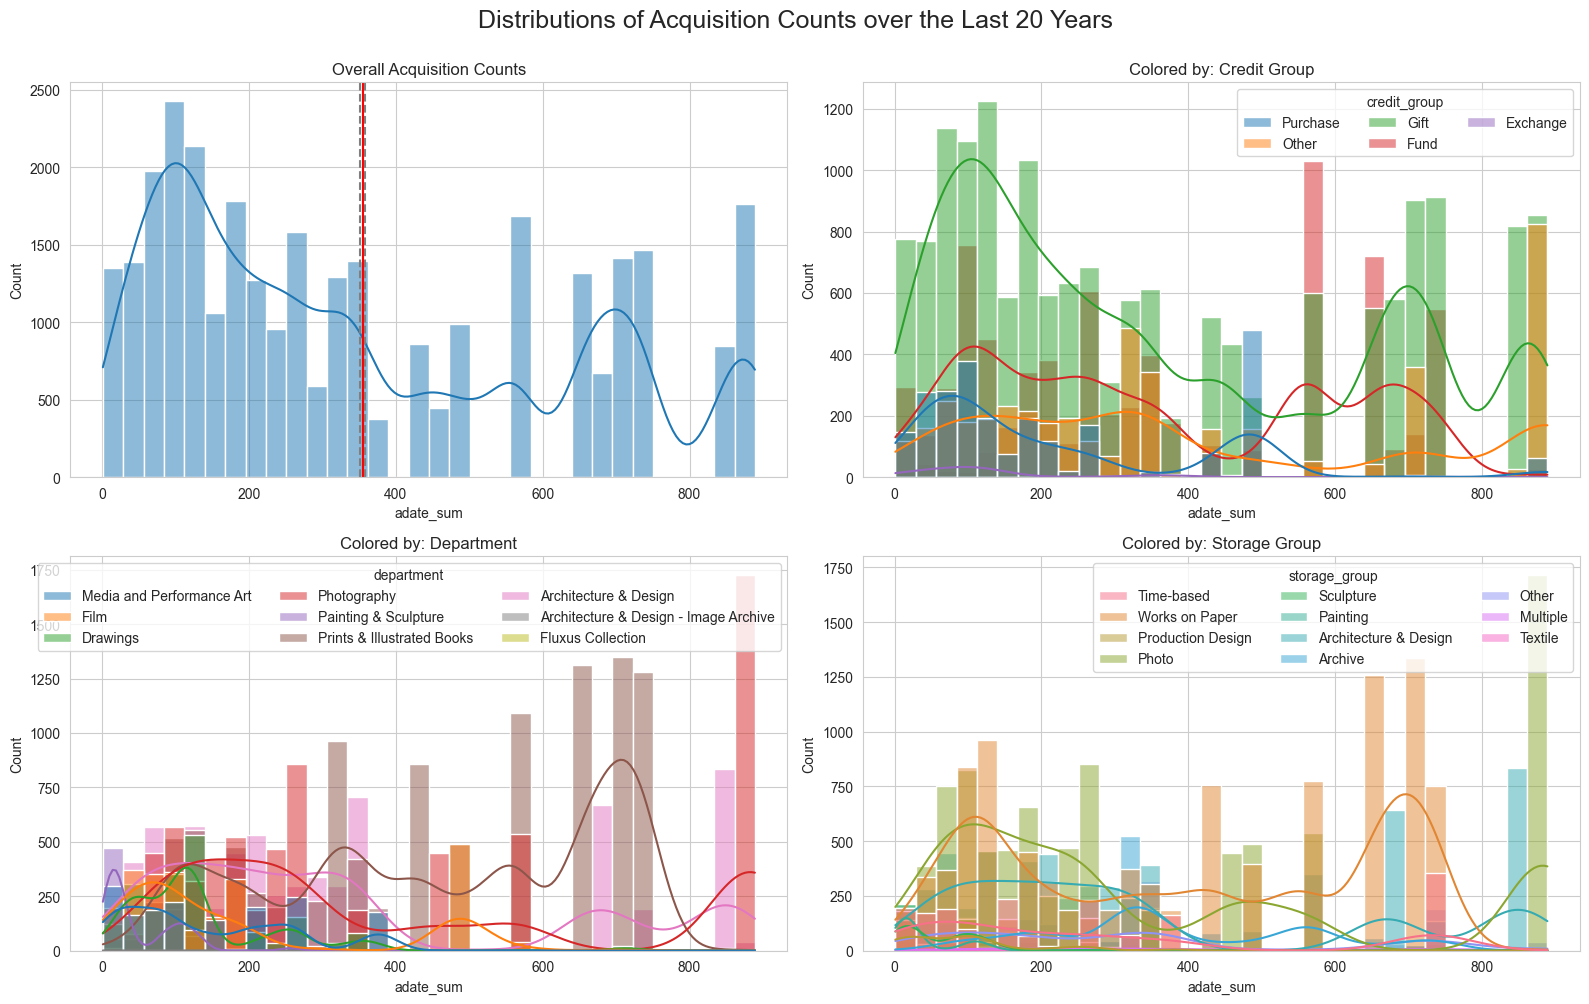

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle("Distributions of Acquisition Counts over the Last 20 Years", fontsize = 18, y = 1.0)
ci = calculate_confidence_intervals_95(datasets["recent_data"], "adate_sum")
sns.histplot(data=datasets["recent_data"], x = "adate_sum", kde = True, ax = axs[0, 0])
axs[0, 0].axvline(np.mean(datasets["recent_data"]["adate_sum"]), color = "red")
axs[0, 0].axvline(ci[0], color="gray", linestyle = "--")
axs[0, 0].axvline(ci[1], color="gray", linestyle = "--")
axs[0, 0].set_title("Overall Acquisition Counts")

for i, column in enumerate(hue_categories, 1):
    column_title = column.title().replace("_", " ")
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    sns.histplot(data=datasets["recent_data"], x = "adate_sum", hue = column, kde = True, ax = ax)
    ax.set_title(f"Colored by: {column_title}")
    sns.move_legend(ax, loc = "upper right", ncol=3)

    plt.tight_layout()
plt.show()
plt.close()

Text(0.5, 1.0, 'Date of Works plotted against Acquisition Dates')

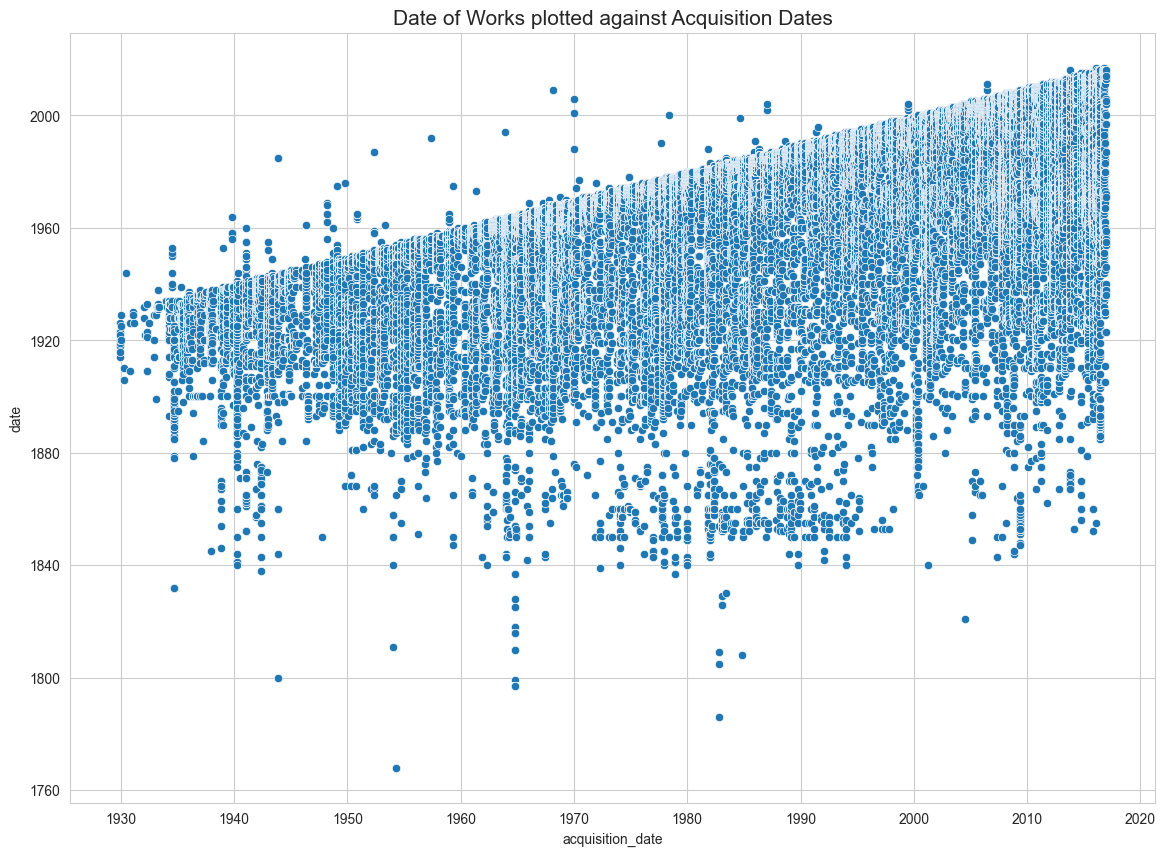

In [36]:
# Table: How contemporary are the intake practices of the NYC MoMA?
plt.figure(figsize = (14, 10))
sns.scatterplot(datasets["artworks_tsdata"], x = "acquisition_date", y = "date")
plt.title("Date of Works plotted against Acquisition Dates", fontsize = 15, y = 1.0)

<section id="spatial-stats">
    <h2>Spatial Descriptive Statistics - Histograms, Boxplots, and Totals by [Overall, Credit, Dept, Storage_Group]</h2>
</section>

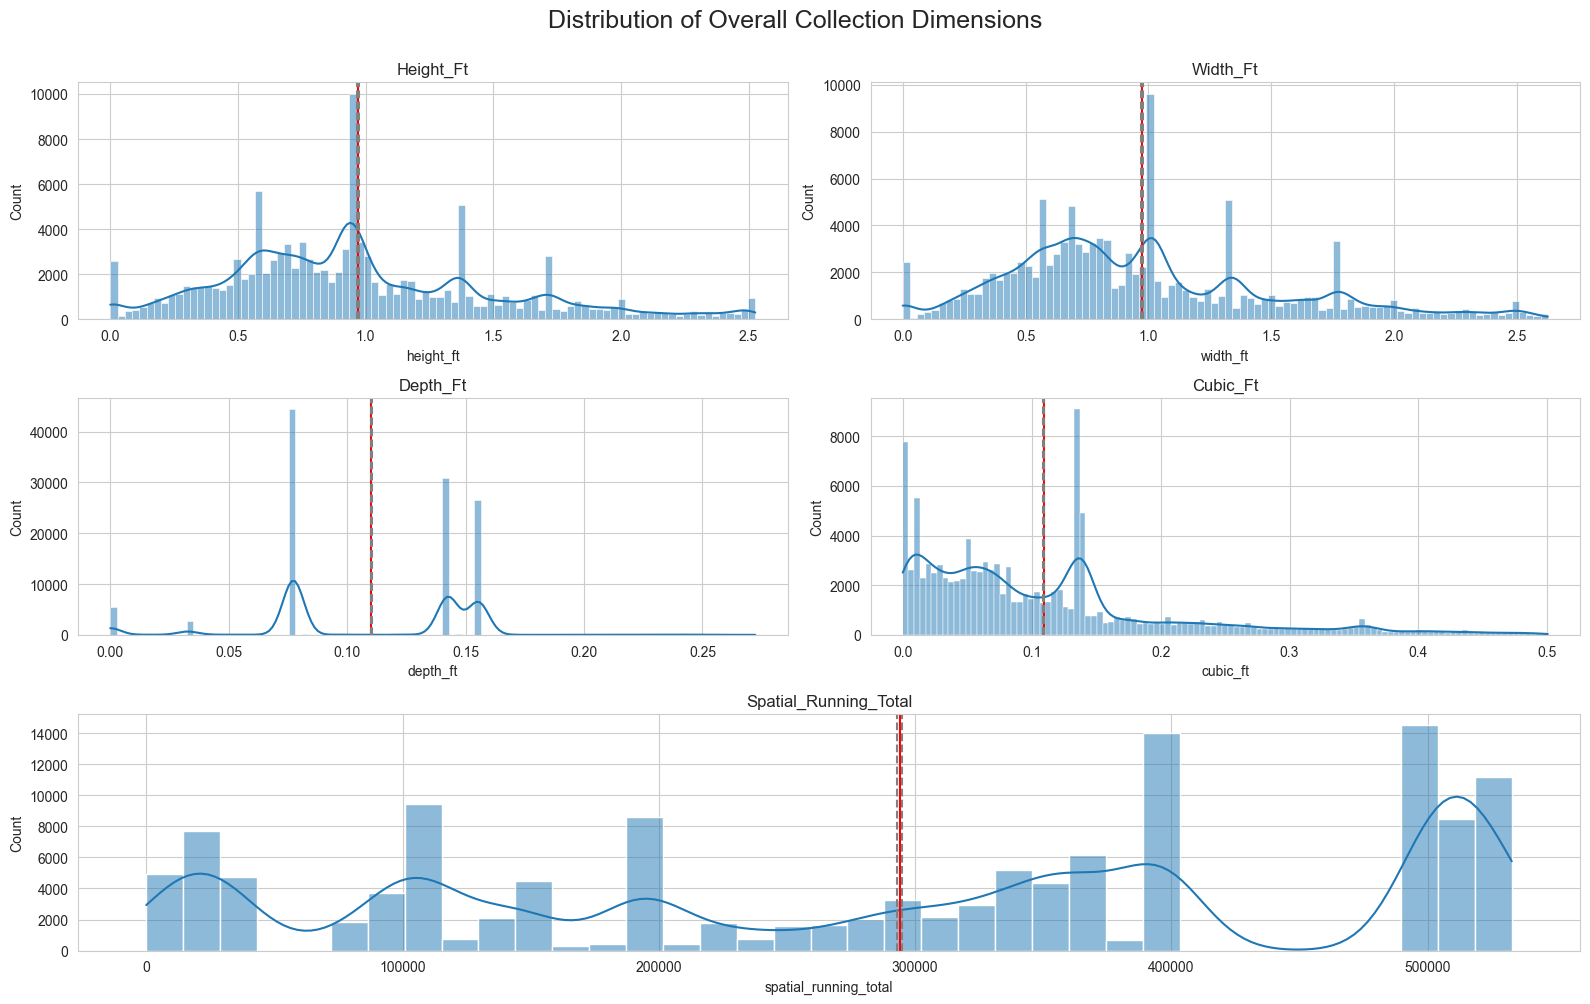

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(16, 10))
plt.suptitle(f"Distribution of Overall Collection Dimensions", fontsize = 18, y = 1.0)

for i, column in enumerate(spatial_columns[:-1]):
    ax = axs[i // 2, i % 2]  # Calculate row and column index
    ci = calculate_confidence_intervals_95(datasets["artworks_data"], column)
    sns.histplot(data=datasets["artworks_data"], x = column, ax = ax, kde = True)
    ax.axvline(np.mean(datasets["artworks_data"][column]), color = "red")
    ax.axvline(ci[0], color="gray", linestyle = "--")
    ax.axvline(ci[1], color="gray", linestyle = "--")
    ax.set_title(column.title())
axs[2, 1].remove()
axs[2, 0].remove()

combined_ax = fig.add_subplot(3, 1, 3)  # combined plot row
sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", ax = combined_ax, kde = True)
ci = calculate_confidence_intervals_95(datasets["artworks_data"], "spatial_running_total")
combined_ax.axvline(np.mean(datasets["artworks_data"]["spatial_running_total"]), color="red")
combined_ax.axvline(ci[0], color="gray", linestyle = "--")
combined_ax.axvline(ci[1], color="gray", linestyle = "--")
combined_ax.set_title("spatial_running_total".title())
plt.tight_layout()
plt.show()
plt.close(fig)

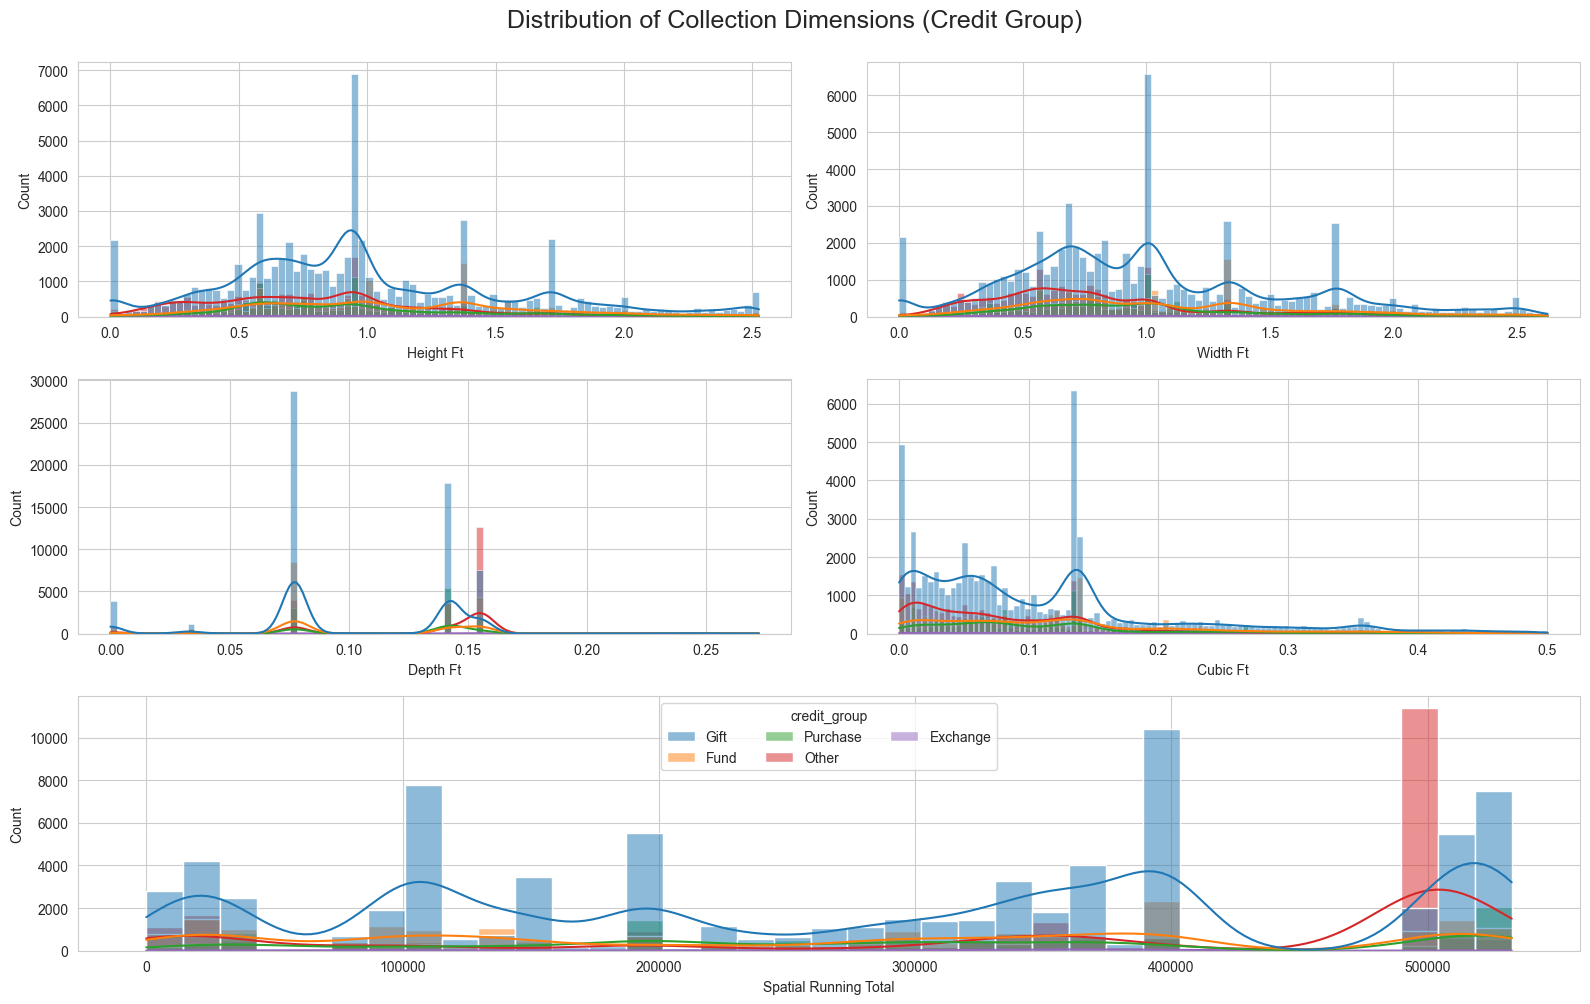

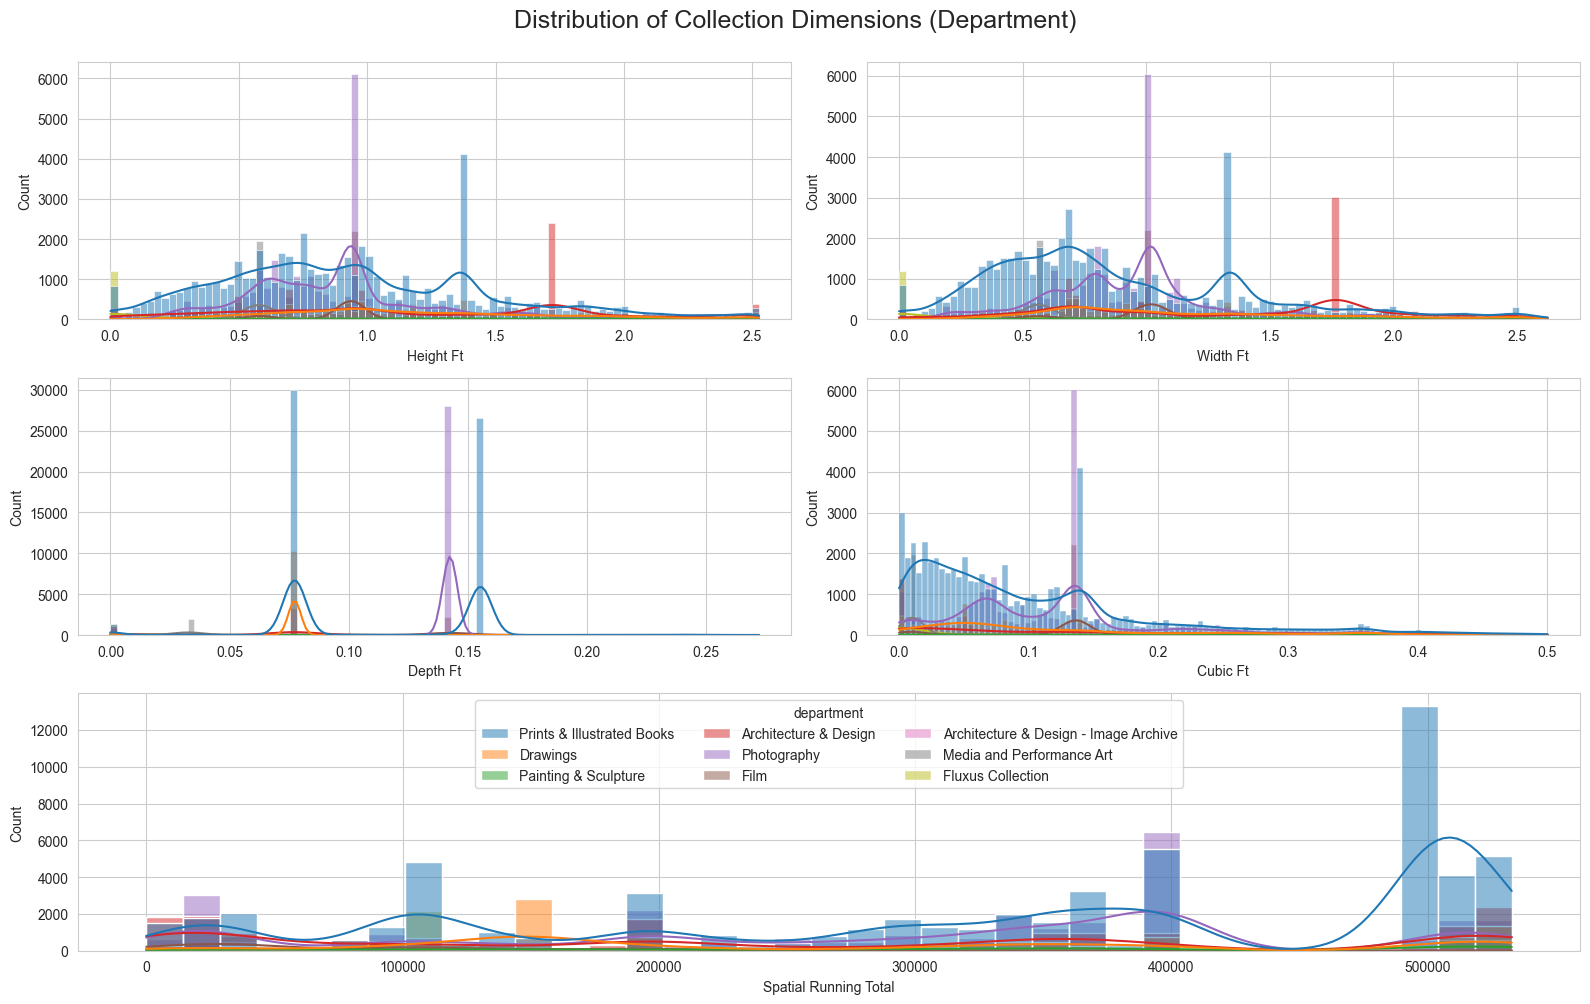

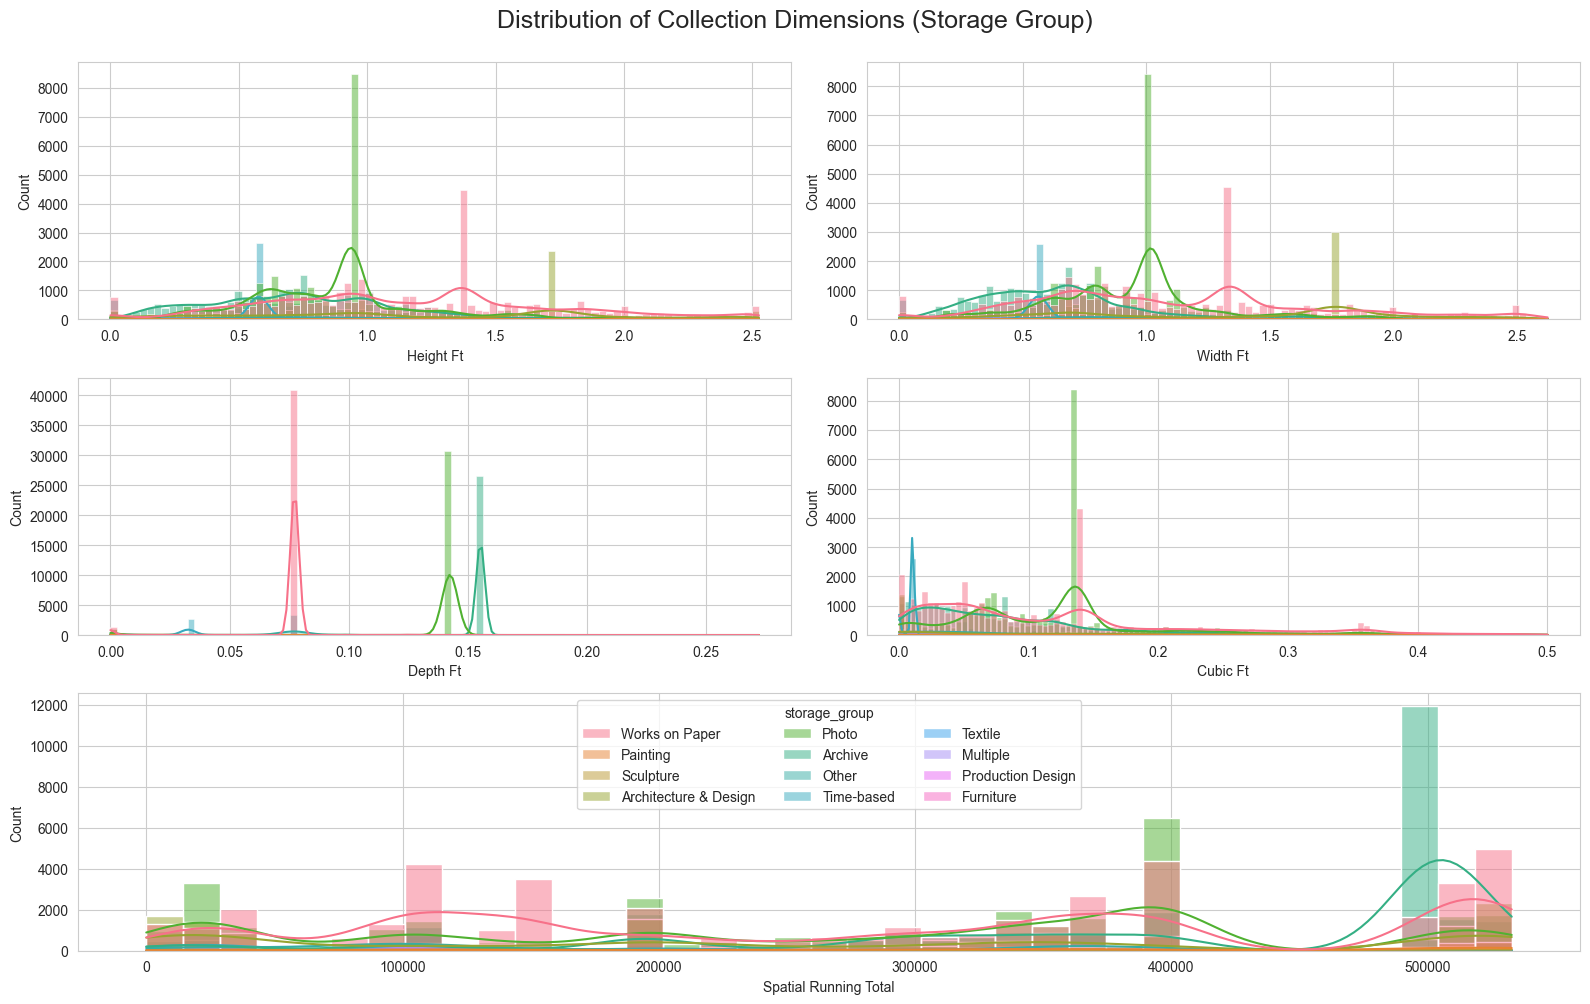

In [38]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.histplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, kde = True, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.histplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax, kde = True)
    sns.move_legend(combined_ax, loc = "upper center", ncol = 3)
    combined_ax.set_xlabel("spatial running total".title())
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [39]:
# Spatial totals by department and storage group
# fig, axs = plt.subplots(3, 2, figsize=(16, 10))
# data = datasets["artworks_data"].groupby("department").sum()
# plt.suptitle(f"Totals of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

# for i, column in enumerate(spatial_columns[:-1]):
#     for idx, column in enumerate(spatial_columns, 1):
#         ax = axs[i // 2, i % 2]  # Calculate row and column index
#         # Acquistion date counts
#         # plt.subplot(4, 1, idx)
#         sns.countplot(
#             y = column,
#             data = data,
#             # sorts plots by descending order for visual clarity
#             # order = datasets["artworks_data"][column].sum(),
#             color = sns.color_palette("deep")[0]
#         )
#         plt.title(f"Intake Counts by {category.replace('_', ' ').title()}")
# plt.tight_layout()
# plt.show()

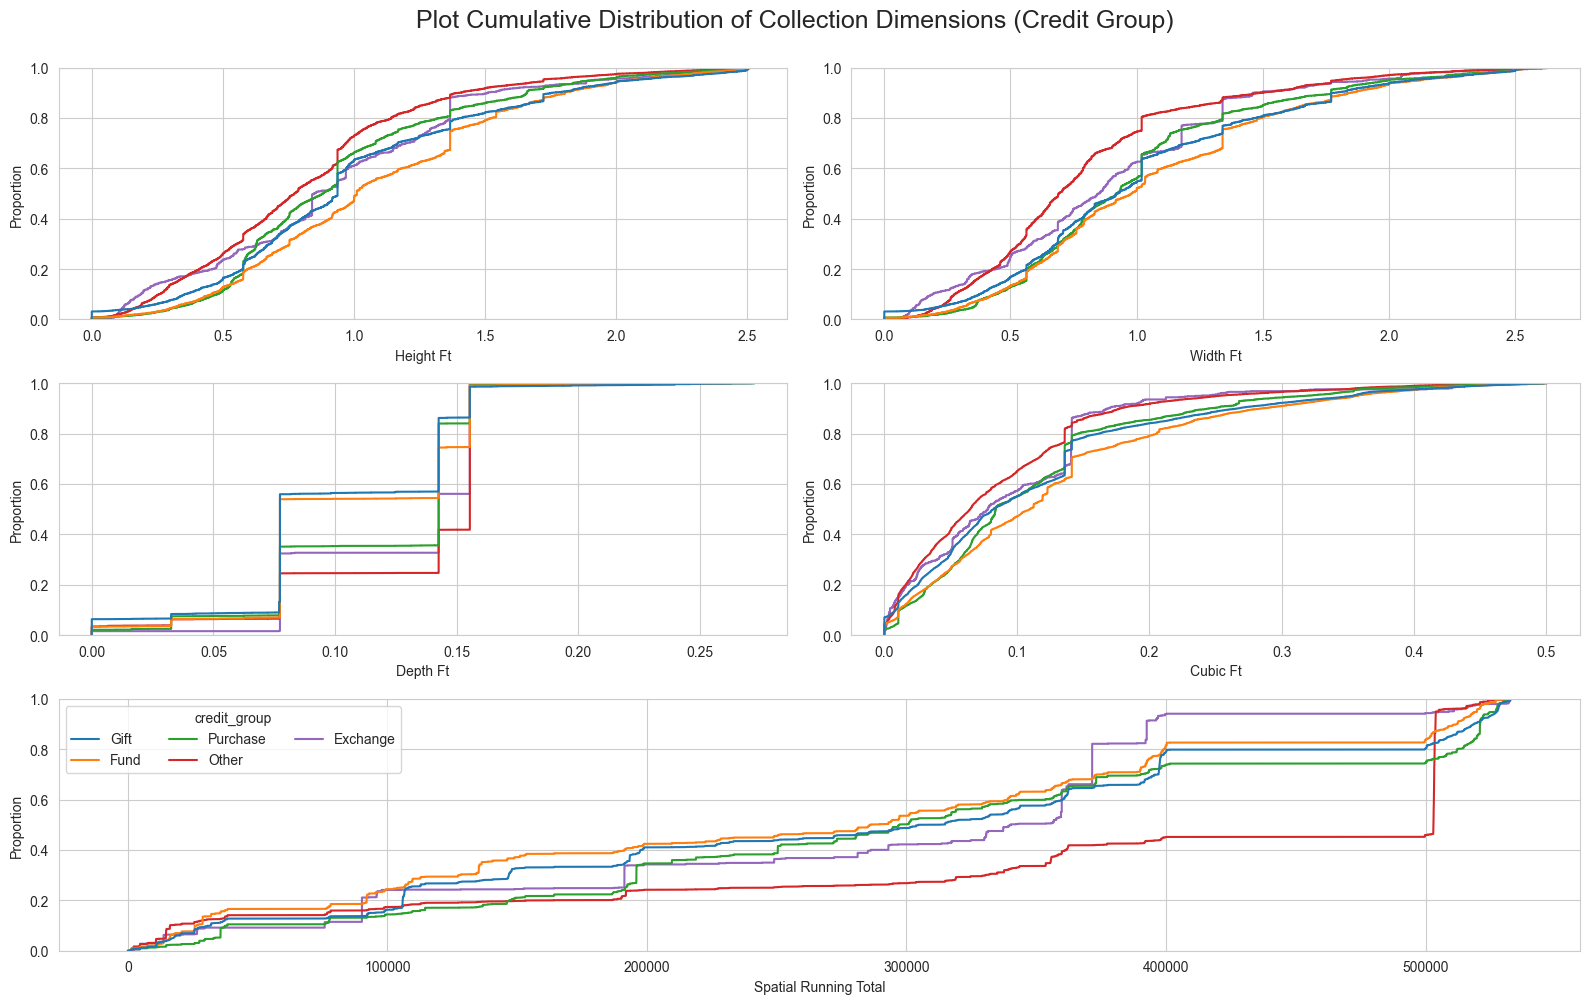

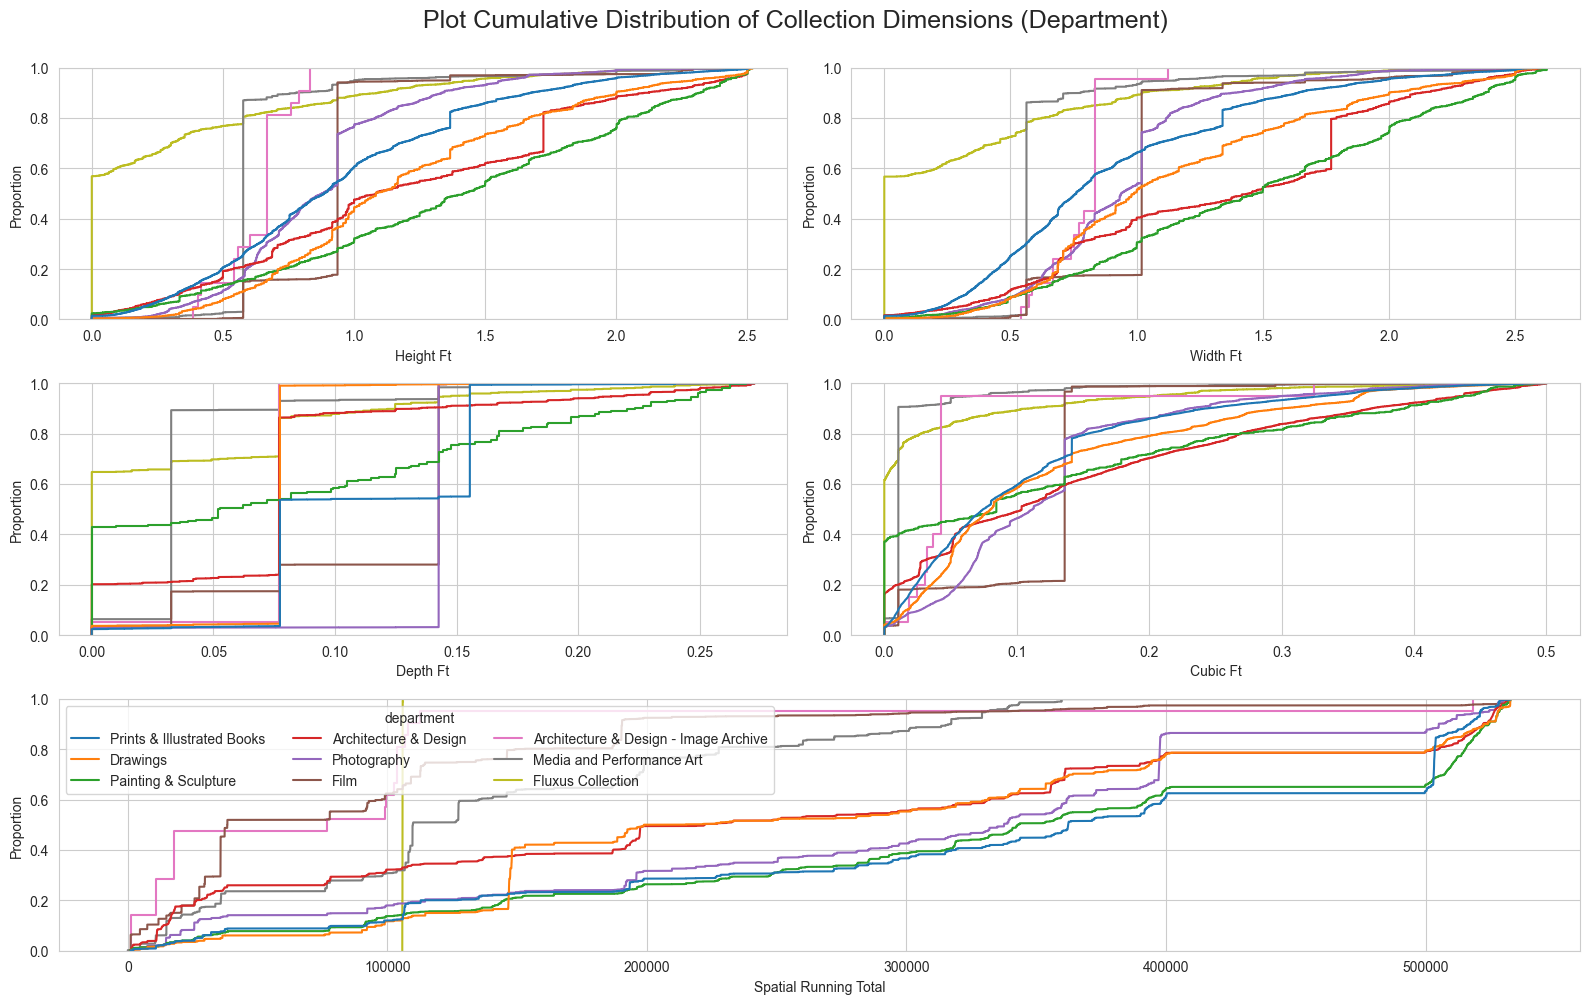

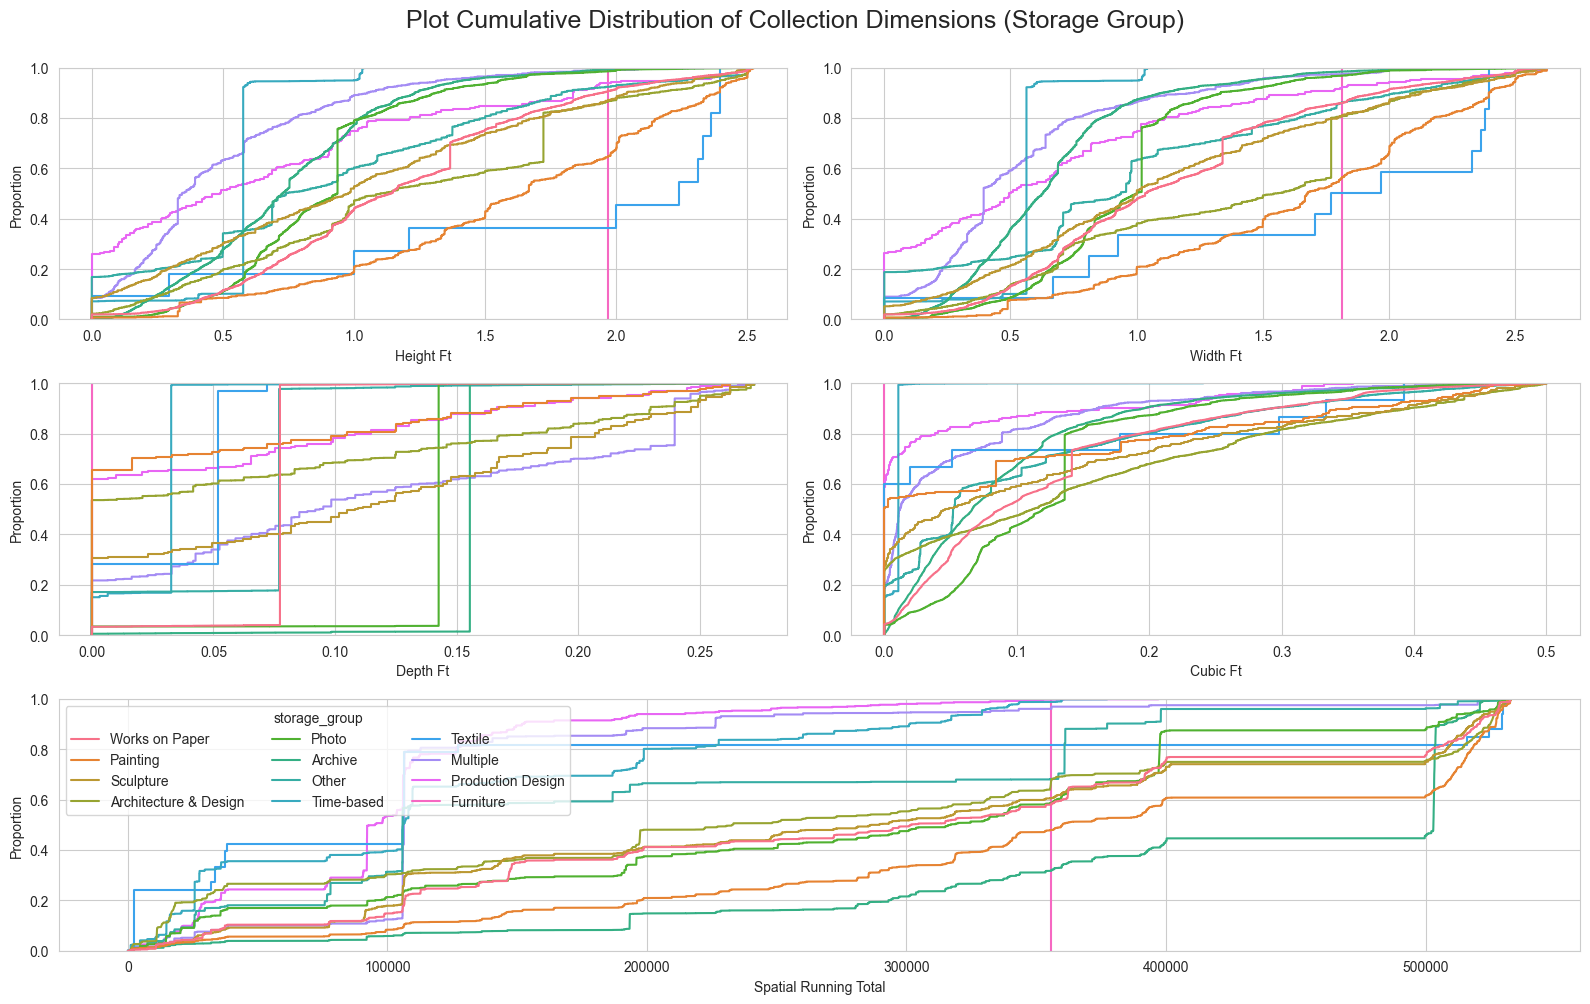

In [40]:
for category in hue_categories:
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    plt.suptitle(f"Plot Cumulative Distribution of Collection Dimensions ({category.title().replace('_', ' ')})", fontsize = 18, y = 1.0)

    for i, column in enumerate(spatial_columns[:-1]):
        ax = axs[i // 2, i % 2]  # Calculate row and column index
        sns.ecdfplot(data=datasets["artworks_data"], 
                     x = column, hue = category,
                     ax = ax, legend = False)
        ax.set_xlabel(column.title().replace("_", " "))
    axs[2, 1].remove()
    axs[2, 0].remove()
    
    combined_ax = fig.add_subplot(3, 1, 3)
    sns.ecdfplot(data = datasets["artworks_data"], x = "spatial_running_total", hue = category, ax = combined_ax)
    combined_ax.set_xlabel("spatial running total".title())
    sns.move_legend(combined_ax, loc = "upper left", ncol = 3)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [41]:
(datasets["artworks_data"]
 .groupby("department")
 .describe()  # Descriptive Statistics Table by Department
 .T  # Transpose for a nice view
 )

department                   Architecture & Design  \
height_ft             count              14882.000   
                      mean                   1.197   
                      std                    0.669   
                      min                    0.000   
                      25%                    0.688   
                      50%                    1.083   
                      75%                    1.722   
                      max                    2.526   
width_ft              count              14988.000   
                      mean                   1.318   
                      std                    0.657   
                      min                    0.000   
                      25%                    0.708   
                      50%                    1.448   
                      75%                    1.770   
                      max                    2.625   
depth_ft              count               5298.000   
                      mean                   0.075   
                      std                    0.057   
                      min                    0.000   
                      25%                    0.077   
                      50%                    0.077   
                      75%                    0.077   
                      max                    0.272   
cubic_ft              count               7530.000   
                      mean                   0.143   
                      std                    0.140   
                      min                    0.000   
                      25%                    0.026   
                      50%                    0.104   
                      75%                    0.238   
                      max                    0.500   
spatial_running_total count              18269.000   
                      mean              248680.493   
                      std               188398.548   
                      min                  792.058   
                      25%                37272.518   
                      50%               222266.380   
                      75%               394674.698   
                      max               532823.569   
adate_sum             count              18168.000   
                      mean                 310.590   
                      std                  279.366   
                      min                    1.000   
                      25%                   91.000   
                      50%                  213.000   
                      75%                  453.000   
                      max                 1641.000   

department                   Architecture & Design - Image Archive   Drawings  \
height_ft             count                                 21.000   9988.000   
                      mean                                   0.635      1.200   
                      std                                    0.126      0.550   
                      min                                    0.385      0.000   
                      25%                                    0.557      0.813   
                      50%                                    0.667      1.083   
                      75%                                    0.667      1.567   
                      max                                    0.833      2.526   
width_ft              count                                 21.000   9939.000   
                      mean                                   0.780      1.149   
                      std                                    0.126      0.576   
                      min                                    0.542      0.000   
                      25%                                    0.740      0.708   
                      50%                                    0.833      0.990   
                      75%                                    0.833      1.509   
                      max                                

In [42]:
(datasets["artworks_data"]
 .groupby("storage_group")
 .describe()  # Descriptive Statistics Table by Storage Group / Type
 .T  # Transpose for a nice view
 )

storage_group                Architecture & Design    Archive  Furniture  \
height_ft             count              11933.000  26946.000      1.000   
                      mean                   1.209      0.750      1.969   
                      std                    0.690      0.391        NaN   
                      min                    0.000      0.000      1.969   
                      25%                    0.667      0.482      1.969   
                      50%                    1.104      0.728      1.969   
                      75%                    1.722      0.981      1.969   
                      max                    2.526      2.520      1.969   
width_ft              count              12449.000  26797.000      1.000   
                      mean                   1.331      0.667      1.813   
                      std                    0.670      0.371        NaN   
                      min                    0.000      0.000      1.813   
                      25%                    0.692      0.417      1.813   
                      50%                    1.552      0.627      1.813   
                      75%                    1.770      0.801      1.813   
                      max                    2.625      2.585      1.813   
depth_ft              count               1984.000  26944.000      1.000   
                      mean                   0.071      0.154      0.000   
                      std                    0.093      0.014        NaN   
                      min                    0.000      0.000      0.000   
                      25%                    0.000      0.155      0.000   
                      50%                    0.000      0.155      0.000   
                      75%                    0.146      0.155      0.000   
                      max                    0.272      0.269      0.000   
cubic_ft              count               4778.000  26584.000      1.000   
                      mean                   0.147      0.089      0.000   
                      std                    0.150      0.086        NaN   
                      min                    0.000      0.000      0.000   
                      25%                    0.000      0.029      0.000   
                      50%                    0.112      0.066      0.000   
                      75%                    0.260      0.119      0.000   
                      max                    0.500      0.500      0.000   
spatial_running_total count              14956.000  26990.000      1.000   
                      mean              256619.946 399114.240 355790.436   
                      std               192904.477 142329.797        NaN   
                      min                  792.058   1047.275 355790.436   
                      25%                36984.956 317246.862 355790.436   
                      50%               232925.470 503010.880 355790.436   
                      75%               499468.835 503471.481 355790.436   
                      max               532823.569 532715.777 355790.436   
adate_sum             count              14952.000  15663.000      1.000   
                      mean                 290.224    468.805    803.000   
                      std                  272.150    478.739        NaN   
                      min                    1.000      2.000    803.000   
                      25%                   83.000    165.000    803.000   
                      50%                  172.000    306.000    803.000   
                      75%                  453.000    453.000    803.000   
                      max                 1641.000   1692.000    803.000   

storage_group                 Multiple      Other   Painting      Photo  \
height_ft             count   1007.000   3987.000    809.000  31607.000   
                      mean       0.492      0.905      1.574      0.874   
                      std        0.422      0.676 

In [43]:
(datasets["artworks_data"]
 .groupby("credit_group")
 .describe()  # Descriptive Statistics Table by Credit Group
 .T  # Transpose for a nice view
 )

credit_group                  Exchange       Fund       Gift      Other  \
height_ft             count    743.000  18154.000  67763.000  22056.000   
                      mean       0.919      1.084      0.993      0.819   
                      std        0.531      0.528      0.552      0.471   
                      min        0.000      0.000      0.000      0.000   
                      25%        0.533      0.673      0.620      0.492   
                      50%        0.846      1.010      0.937      0.774   
                      75%        1.289      1.375      1.335      1.030   
                      max        2.516      2.526      2.526      2.526   
width_ft              count    749.000  18224.000  68372.000  21868.000   
                      mean       0.886      1.060      1.005      0.798   
                      std        0.521      0.549      0.563      0.478   
                      min        0.000      0.000      0.000      0.000   
                      25%        0.502      0.656      0.623      0.486   
                      50%        0.853      0.979      0.925      0.692   
                      75%        1.178      1.340      1.340      1.020   
                      max        2.625      2.625      2.625      2.625   
depth_ft              count    710.000  17977.000  61188.000  21879.000   
                      mean       0.126      0.107      0.102      0.130   
                      std        0.038      0.044      0.046      0.042   
                      min        0.000      0.000      0.000      0.000   
                      25%        0.077      0.077      0.077      0.143   
                      50%        0.143      0.077      0.077      0.155   
                      75%        0.155      0.155      0.143      0.155   
                      max        0.229      0.271      0.272      0.262   
cubic_ft              count    695.000  17254.000  61132.000  21584.000   
                      mean       0.094      0.127      0.112      0.086   
                      std        0.085      0.106      0.104      0.084   
                      min        0.000      0.000      0.000      0.000   
                      25%        0.025      0.047      0.034      0.022   
                      50%        0.078      0.110      0.082      0.065   
                      75%        0.141      0.174      0.142      0.128   
                      max        0.458      0.500      0.500      0.500   
spatial_running_total count    829.000  19908.000  74221.000  22831.000   
                      mean  276242.188 260940.068 280340.309 364564.900   
                      std   142577.016 170300.640 170010.188 183604.721   
                      min     1057.787    789.644      0.021      0.011   
                      25%   189066.577 105375.087 108033.767 239793.338   
                      50%   340287.038 286085.946 313251.372 503027.203   
                      75%   371542.447 392555.610 397626.007 503408.587   
                      max   532548.957 532833.787 532853.711 532677.583   
adate_sum             count    829.000  19672.000  61654.000  11551.000   
                      mean     202.125    267.374    379.843    371.115   
                      std      164.408    219.638    423.854    366.241   
                      min        1.000      1.000      1.000      1.000   
                      25%       93.000    103.000    100.000    104.500   
                      50%      124.000    200.000    207.000    244.000   
                      75%      322.000    361.000    460.000    481.000   
                      max     1692.000   1692.000   1692.000   1692.000   

credit_group                  Purchase  
height_ft             count  11629.000  
                      mean       0.948  
                      std        0.482  
                      min        0.000  
                      25%        0.591  
                      50%        0.883  
                      75%        1.16

## Conclusions & Recommendations

I will add thinking for how to go about forecasting given our analysis. All of that will be added in this section, which doubles as a high-level overview of the forecasting approach.

Models in consideration:
Naive Forecast, MA, ES, CROSTON, SBA, TBS

Why:
Given that our professional working assumption is that our data as accession-only and accessions counts cannot go below zero, it's necessary to model the data as a "Intermittent Demand-side Forecasting" problem. Borrowing from the field of predictive inventory analytics, this approach allows us to model influxes of objects in a collection without necessitating deaccession data to make predictions about collections growth. In live projects with MMM clients, we anticipate having more flexibility in our model selection processes (because we're not actually working with the MoMA, just their data). As the stand-in for our collections professional client, Samantha, had put forward that they would like to understand any hierarchical relationships within the dataset such as object counts by department and storage group as they filter up to inform the overall total of incoming works.  

What:
For our forecasting process, we will be comparing a couple of standard statistical models to more specified predictive techniques. The client's desired analysis outcomes indicate to me that we will be prioritizing bottom-up hierarchical models which have been designed to perform well in predicting intermittent, incoming quantities. Each of the statistical models have accompanying metrics which describe various aspects of their predictive performance, for the purposes of this demonstration analysis we will be using the following metrics: MSE, RMSE, MAD, etc.